# **Python script to download latest DOME Registry contents, related full text papers & provide DOME Registry entries metadata read out (20241220)**
1. DOME Registry contents will be downloaded by API call providing the json file of DOME Registry data
2. DOME Registry data json will be flattened and converted into TSV for working with entries data (row based data)
3. DOME Registry TSV will be checked and used to produce a metadata readout file (+ graphs)
4. DOME Registry DOIs of articles will be converted to PMCIDs and Europe PMC IDs for full text retrieval 
5. DOME Registry entries will be downloaded as full text PDF files using EPMC API
6. DOME Registry supplementary files will be downloaded using EPMC API
7. DOME Registry title and abstracts enriched in TSV from EPMC to support data analysis
8. Metadata and graphs produced on available DOME Registry articles retrieval

#### To do: dockerise & put into simple run script vs jupyter notebook


## 1. Latest DOME Registry contents will be downloaded by DOME Registry API call providing the .json file of DOME Registry data for the given day 

In [2]:
# 1. Use the DOME API to download all entries of the DOME Registry and store them in a json file 
import os
from datetime import datetime
import requests

# Define the URL for the call
url = "https://registry.dome-ml.org/api/review?skip=0&limit=1000&text=%20&public=true&sort=publication.year&asc=true"

# Make an API request to the URL to check the response
response = requests.get(url, headers={'accept': '*/*'})

# Create folder to store all JSON files
if not os.path.exists('DOME_Registry_JSON_Files'):
    os.makedirs('DOME_Registry_JSON_Files')
    print('Created folder for storing DOME Registry JSON files')
else:
    print('Folder already exists for storing DOME Registry JSON files, files will be stored here')

# Specify the desired folder path for JSON files
json_folder_path = "DOME_Registry_JSON_Files"

# Check if the request was successful
if response.status_code == 200:
    # Get the current date in ISO format for file naming
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Create the output file name 
    file_name = f"DOME_Registry_Contents_{current_date}.json"
    json_file_path = os.path.join(json_folder_path, file_name)

    # Print number of entries returned by API
    try:
        entries_count = len(response.json())
        print(f"Number of DOME Registry entries returned from API: {entries_count}")
    except Exception as e:
        print(f"Could not determine number of entries: {e}")

    # Check if the file pathway already exists
    if os.path.exists(json_file_path):
        print(f"File already exists for today's date: {json_file_path}")
        print('Skipping download. Delete the file manually if you want to re-download.')
        print('Continuing with existing file...')
    else:
        print('Downloading new file...')
        # Save the content to a file
        with open(json_file_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"DOME Registry data downloaded and saved to '{json_file_path}'")
    
    print(f"Using file: {json_file_path}")
else:
    print(f"Failed to retrieve the data. Status code: {response.status_code}")
    # Set json_file_path to None to prevent errors in subsequent cells
    json_file_path = None

print("Block 1 complete.")

Folder already exists for storing DOME Registry JSON files, files will be stored here
Number of DOME Registry entries returned from API: 280
DOME Registry data downloaded and saved to 'DOME_Registry_JSON_Files/DOME_Registry_Contents_2026-01-09.json'
Using file: DOME_Registry_JSON_Files/DOME_Registry_Contents_2026-01-09.json
Block 1 complete.


## 2. DOME Registry data .json file will be flattened and converted into TSV for easier working with entries data (row and column based data format)

In [3]:
# 2. Produce DOME Registry contents metadata .tsv file and data visualisation
import json

# 2.1 Pretty print DOME Registry contents JSON file for inspection to ensure all looks as expected 
# remove comment to activate print and debug where needed

# Function to read in and pretty-print the JSON DOME Registry file entry
def pretty_print_json(file_name):
    try:
        # Open and read the JSON file
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Pretty-print the JSON data
        print('Successfully read in JSON file.')
        #print(json.dumps(data, indent=4))
    
    except Exception as e:
        print(f"Error reading the JSON file: {e}")

# Call the function to pretty-print the JSON file
pretty_print_json(json_file_path)


# 2.2 Flatten the JSON for easier data processing and write to a new .json file 
# Function to read JSON data
def read_json(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"Error reading the JSON file: {e}")
        return None

# Function to flatten JSON
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Function to save flattened JSON to a file
def save_flattened_json(flattened_data, output_file_name):
    try:
        with open(output_file_name, 'w', encoding='utf-8') as file:
            json.dump(flattened_data, file, indent=4)
        print(f"Flattened JSON data saved to '{output_file_name}'")
    except Exception as e:
        print(f"Error saving the flattened JSON file: {e}")

# Read JSON data
data = read_json(json_file_path)

# Flatten JSON data and save to a new JSON file
if data:
    flattened_data = [flatten_json(entry) for entry in data]
    flattened_file_name = ("flattened_"+file_name)
    # Make file path to save flattened JSON file
    json_folder_path = "DOME_Registry_JSON_Files"
    json_file_path = os.path.join(json_folder_path, flattened_file_name)
    save_flattened_json(flattened_data, json_file_path)
    # Print the flattened JSON data to view it

else:
    print("No data to process.")

#2.3 Convert flattened json to tsv 
# Function to read flattened JSON data
import json
import csv
import os

# Function to read flattened JSON data
def read_flattened_json(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"Error reading the flattened JSON file: {e}")
        return None

# TSV folders created to store tsv
if not os.path.exists('DOME_Registry_TSV_Files'):
    print('Creating folder to store DOME Registry TSV files')
    os.makedirs('DOME_Registry_TSV_Files')
else:
    print('Folder already exists for storing DOME Registry TSV files')

# Function to write JSON data to a TSV file
def write_json_to_tsv(json_data, tsv_file_name):
    try:
        # Determine all possible headers from the entire dataset
        headers = set()
        for entry in json_data:
            headers.update(entry.keys())
        headers = list(headers)
        
        # Write data to TSV file
        with open(tsv_file_name, 'w', newline='', encoding='utf-8') as tsvfile:
            writer = csv.DictWriter(tsvfile, fieldnames=headers, delimiter='\t')
            writer.writeheader()
            for entry in json_data:
                writer.writerow(entry)
        
        print(f"JSON data written to '{tsv_file_name}'")
    except Exception as e:
        print(f"Error writing to the TSV file: {e}")

# Read flattened JSON data
flattened_data = read_flattened_json(json_file_path)

# Create TSV file name and file pathway
tsv_file_name = flattened_file_name[:-5]+'.tsv'
tsv_file_path = os.path.join('DOME_Registry_TSV_Files', tsv_file_name)

# Process JSON data into TSV
if flattened_data:
    write_json_to_tsv(flattened_data, tsv_file_path)
else:
    print("No data to process.")

tsv_file_name = flattened_file_name[:-5]+'.tsv'

Successfully read in JSON file.
Flattened JSON data saved to 'DOME_Registry_JSON_Files/flattened_DOME_Registry_Contents_2026-01-09.json'
Folder already exists for storing DOME Registry TSV files
JSON data written to 'DOME_Registry_TSV_Files/flattened_DOME_Registry_Contents_2026-01-09.tsv'


## 3. DOME Registry TSV data file will be formatted with shortid as the row index and other fields cleaned (publication data) and ordered by D O M E fields 

In [4]:
#3 Reorder TSV using pandas data frame 
import pandas as pd

# Read the TSV file as a DataFrame using pandas
df = pd.read_csv(tsv_file_path, sep='\t')

# Define the prefixes to match and group tsv data
prefix_publications_cols = 'publication_'
prefix_tags_cols = 'publication_tags_'
prefix_data_cols = 'matches_data'
prefix_optimization_cols = 'matches_optimization'
prefix_model_cols = 'matches_model'
prefix_evaluation_cols = 'matches_evaluation'

# Separate columns based on whether they start with the prefix
publication_columns = [col for col in df.columns if col.startswith(prefix_publications_cols) and not col.startswith(prefix_tags_cols)]
publication_tags_columns = [col for col in df.columns if col.startswith(prefix_tags_cols)]
# Sort tags columns numerically (e.g., publication_tags_0, publication_tags_1, ...)
publication_tags_columns = sorted(publication_tags_columns, key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0)
matches_data_columns = [col for col in df.columns if col.startswith(prefix_data_cols)]
matches_optimization_columns = [col for col in df.columns if col.startswith(prefix_optimization_cols)]
matches_model_columns = [col for col in df.columns if col.startswith(prefix_model_cols)]
matches_evaluation_columns = [col for col in df.columns if col.startswith(prefix_evaluation_cols)]
other_columns = [col for col in df.columns if not col.startswith('matches_') and not col.startswith('publication_')]

# Reorder columns
reordered_columns = (other_columns + publication_columns + publication_tags_columns + matches_data_columns +
                     matches_optimization_columns + matches_model_columns + matches_evaluation_columns)
df = df[reordered_columns]

# Print the reordered DataFrame
#print(df.head())

df = pd.DataFrame(df).set_index('shortid')
df.to_csv(tsv_file_path, sep='\t', index=True, encoding='utf-8') 

print(f"Reordered TSV data saved to '{tsv_file_path}'")

Reordered TSV data saved to 'DOME_Registry_TSV_Files/flattened_DOME_Registry_Contents_2026-01-09.tsv'


## 4. DOME Registry data tsv will have columns added with PMCIDs and Europe PMC IDs returned from DOI search using NCBI E-Utilities API 

In [5]:
# 4. From DOIs get PMCIDs and Europe PMC IDs for full text search
import pandas as pd
import requests
import re
import os

# Define output file name based on current date
output_tsv_file_name = f'DOME_Registry_TSV_Files/PMCIDs_DOME_Registry_Contents_{current_date}.tsv'

# Check if output file already exists to avoid re-running time intensive API calls
if os.path.exists(output_tsv_file_name):
    print(f"Found existing output file: {output_tsv_file_name}")
    df = pd.read_csv(output_tsv_file_name, sep='\t')
    
    # Check if mapping columns exist
    if all(col in df.columns for col in ['mapped_pmcid', 'mapped_europepmc_id', 'mapped_pmid']):
        print("Mapping columns already exist in the output file.")
        print("Skipping DOI mapping API calls to avoid duplication.")
        need_mapping = False
    else:
        print("Output file exists but mapping columns are missing. Proceeding with mapping...")
        need_mapping = True
else:
    print(f"Output file not found. Reading input file: {tsv_file_path}")
    # Read in DOME Entries TSV as dataframe via pandas library functions
    df = pd.read_csv(tsv_file_path, sep='\t')
    need_mapping = True

# Only proceed with mapping if needed
if need_mapping:
    # Extract DOIs from the DataFrame
    raw_dois = df['publication_doi'].dropna().unique()
    print(f"Found {len(raw_dois)} unique raw DOIs to process")

    # Function to clean and normalize DOI strings
    def clean_doi(doi_string):
        """
        Clean DOI string by removing common prefixes and URLs.
        Handles formats like:
        - https://doi.org/10.1038/nature123
        - http://dx.doi.org/10.1016/j.cell.2020
        - doi:10.1126/science.abc456
        - 10.1002/anie.202100001
        
        Returns clean DOI like: 10.1038/nature123
        """
        if pd.isna(doi_string):
            return None
        
        # Convert to string and strip whitespace
        doi_string = str(doi_string).strip()
        
        # Remove common URL prefixes
        doi_string = re.sub(r'^https?://doi\.org/', '', doi_string, flags=re.IGNORECASE)
        doi_string = re.sub(r'^https?://dx\.doi\.org/', '', doi_string, flags=re.IGNORECASE)
        doi_string = re.sub(r'^https?://www\.doi\.org/', '', doi_string, flags=re.IGNORECASE)
        
        # Remove 'doi:' prefix
        doi_string = re.sub(r'^doi:\s*', '', doi_string, flags=re.IGNORECASE)
        
        # Strip any remaining whitespace
        doi_string = doi_string.strip()
        
        # Validate that it starts with '10.' (all DOIs start with 10.)
        if not doi_string.startswith('10.'):
            return None
        
        return doi_string

    # Clean the DOIs and report issues
    print("Cleaning DOI strings...")
    dois = []
    for raw_doi in raw_dois:
        cleaned = clean_doi(raw_doi)
        if cleaned:
            dois.append(cleaned)
        else:
            print(f"  ⚠ Issue extracting/validating DOI: '{raw_doi}'")
            
    print(f"Cleaned {len(dois)} DOIs for processing\n")

    # Map DOIs to PMCIDs and Europe PMC IDs using NCBI E-utilities API
    def map_dois_to_ids(dois, batch_size=1):
        id_mapping = {}
        success_count = 0
        fail_count = 0
        
        print(f"Starting DOI-to-PMCID mapping for {len(dois)} DOIs...")
        print(f"{'='*60}\n")
        
        for i in range(0, len(dois), batch_size):
            batch = dois[i:i + batch_size]
            doi_str = ','.join(batch)
            
            # Progress indicator
            progress = i + len(batch)
            print(f"[{progress}/{len(dois)}] Processing: {batch[0][:50]}...")
            
            url = f"https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids={doi_str}&format=json"
            
            try:
                response = requests.get(url, timeout=30)
                
                if response.status_code == 200:
                    data = response.json()
                    records = data.get('records', [])
                    if records:
                        for record in records:
                            doi = record.get('doi')
                            pmcid = record.get('pmcid')
                            pmid = record.get('pmid')
                            # Europe PMC ID is typically the PMCID without the 'PMC' prefix, or the PMID
                            europepmc_id = pmcid if pmcid else (f"MED/{pmid}" if pmid else None)
                            id_mapping[doi] = {
                                'pmcid': pmcid,
                                'europepmc_id': europepmc_id,
                                'pmid': pmid
                            }
                            
                            if pmcid:
                                print(f"  ✓ Mapped to PMCID: {pmcid}")
                                success_count += 1
                            elif pmid:
                                print(f"  ✓ Mapped to PMID: {pmid} (no PMCID)")
                                success_count += 1
                            else:
                                print(f"  ✗ No PMCID/PMID found")
                                fail_count += 1
                    else:
                        print(f"  ✗ No mapping found")
                        for doi in batch:
                            id_mapping[doi] = {'pmcid': None, 'europepmc_id': None, 'pmid': None}
                        fail_count += 1
                else:
                    print(f"  ✗ API Error (status {response.status_code})")
                    for doi in batch:
                        id_mapping[doi] = {'pmcid': None, 'europepmc_id': None, 'pmid': None}
                    fail_count += 1
            
            except Exception as e:
                print(f"  ✗ Error: {str(e)}")
                for doi in batch:
                    id_mapping[doi] = {'pmcid': None, 'europepmc_id': None, 'pmid': None}
                fail_count += 1
            
            # Rate limiting - be respectful to the API
            if i + batch_size < len(dois):
                import time
                time.sleep(0.3)
        
        print(f"\n{'='*60}")
        print(f"DOI-TO-PMCID MAPPING SUMMARY")
        print(f"{'='*60}")
        print(f"Successfully mapped: {success_count}")
        print(f"Failed/not available: {fail_count}")
        print(f"Success rate: {success_count/len(dois)*100:.1f}%")
        print(f"{'='*60}\n")
        
        return id_mapping

    # Map DOIs to PMCIDs and Europe PMC IDs
    doi_to_id_mapping = map_dois_to_ids(dois)

    # Add the mapped IDs to the DataFrame
    print("Adding mapped IDs to DataFrame...")
    # Use clean_doi helper for lookup to ensure keys match
    df['mapped_pmcid'] = df['publication_doi'].apply(lambda x: doi_to_id_mapping.get(clean_doi(x) if pd.notna(x) else None, {}).get('pmcid'))
    df['mapped_europepmc_id'] = df['publication_doi'].apply(lambda x: doi_to_id_mapping.get(clean_doi(x) if pd.notna(x) else None, {}).get('europepmc_id'))
    df['mapped_pmid'] = df['publication_doi'].apply(lambda x: doi_to_id_mapping.get(clean_doi(x) if pd.notna(x) else None, {}).get('pmid'))

    # Save the updated DataFrame to a new TSV file
    df.to_csv(output_tsv_file_name, sep='\t', index=False)
    print(f"✓ Updated DataFrame with mapped PMCIDs and Europe PMC IDs saved to '{output_tsv_file_name}'")

print("\nBlock 4 complete.")

Output file not found. Reading input file: DOME_Registry_TSV_Files/flattened_DOME_Registry_Contents_2026-01-09.tsv
Found 268 unique raw DOIs to process
Cleaning DOI strings...
  ⚠ Issue extracting/validating DOI: '-'
  ⚠ Issue extracting/validating DOI: 'doi.org/10.1093/nar/gkae385'
Cleaned 266 DOIs for processing

Starting DOI-to-PMCID mapping for 266 DOIs...

[1/266] Processing: 10.1186/1471-2105-7-116...
  ✓ Mapped to PMCID: PMC1421439
[2/266] Processing: 10.1186/1471-2105-8-S5-S3...
  ✓ Mapped to PMCID: PMC1892091
[3/266] Processing: 10.1186/1471-2105-8-358...
  ✓ Mapped to PMCID: PMC2213690
[4/266] Processing: 10.1186/1471-2164-8-78...
  ✓ Mapped to PMCID: PMC1847686
[5/266] Processing: 10.1186/1471-2105-9-389...
  ✓ Mapped to PMCID: PMC2561051
[6/266] Processing: 10.1186/1471-2105-9-57...
  ✓ Mapped to PMCID: PMC2275242
[7/266] Processing: 10.1093/bioinformatics/btn189...
  ✓ Mapped to PMCID: PMC2665034
[8/266] Processing: 10.1186/1471-2105-9-S12-S18...
  ✓ Mapped to PMCID: PMC26

## 4.5 Integrate manually remediated PMID/PMCID values from remediation file if available

In [6]:
# 4.5 Check for remediation file and integrate manually remediated PMID/PMCID values
import pandas as pd
import os
import glob

print("="*60)
print("CHECKING FOR REMEDIATION FILE")
print("="*60)

# Look for remediation files in the TSV folder (where user manually saves remediated files)
tsv_folder = 'DOME_Registry_TSV_Files'
remediation_pattern = os.path.join(tsv_folder, 'remediated_Failed_DOI_Mappings_*.tsv')

remediation_files = glob.glob(remediation_pattern)

if not remediation_files:
    print("\nNo remediation file found.")
    print("Skipping remediation integration.")
    print("If you have manually remediated DOIs, ensure the file is saved as:")
    print(f"  {tsv_folder}/remediated_Failed_DOI_Mappings_YYYY-MM-DD.tsv")
    print("\nProceeding to next step...")
else:
    # Sort files by modification time (oldest first) to process in order
    remediation_files = sorted(remediation_files, key=os.path.getmtime)
    print(f"\n✓ Found {len(remediation_files)} remediation file(s):")
    for f in remediation_files:
        print(f"    - {os.path.basename(f)}")
    
    try:
        # Read the main TSV file
        df_main = pd.read_csv(output_tsv_file_name, sep='\t')
        
        total_updates = 0
        total_pmcid_updates = 0
        total_pmid_updates = 0
        
        # Process each remediation file
        for remediation_file in remediation_files:
            print(f"\n{'='*60}")
            print(f"Processing: {os.path.basename(remediation_file)}")
            print(f"{'='*60}")
            
            # Read the remediation file
            df_remediation = pd.read_csv(remediation_file, sep='\t')
            
            print(f"Remediation file contains {len(df_remediation)} entries")
            
            # Filter for entries that have been manually remediated
            df_remediated = df_remediation[
                (df_remediation['Remediation_Status'] == 'RESOLVED') &
                ((df_remediation['Manual_PMCID'].notna()) | (df_remediation['Manual_PMID'].notna()))
            ]
            
            remediated_count = len(df_remediated)
            
            if remediated_count == 0:
                print("⚠ No manually remediated entries found in this file.")
                print("   (No entries with Remediation_Status='RESOLVED' and Manual PMID/PMCID)")
                continue
            
            print(f"Found {remediated_count} manually remediated entries")
            print("Integrating remediated values...")
            
            file_updates = 0
            file_pmcid_updates = 0
            file_pmid_updates = 0
            
            # Determine the identifier column (shortid or _id)
            id_col = 'shortid' if 'shortid' in df_remediated.columns else '_id'
            
            if id_col not in df_main.columns:
                print(f"✗ Error: Identifier column '{id_col}' not found in main dataset")
                print("   Cannot integrate remediation data from this file")
                continue
            
            # Iterate through remediated entries
            for idx, remediated_row in df_remediated.iterrows():
                entry_id = remediated_row.get(id_col)
                manual_pmcid = remediated_row.get('Manual_PMCID')
                manual_pmid = remediated_row.get('Manual_PMID')
                
                if pd.isna(entry_id):
                    continue
                
                # Find matching row in main dataframe
                mask = df_main[id_col] == entry_id
                matching_rows = df_main[mask]
                
                if len(matching_rows) == 0:
                    print(f"  ⚠ Warning: Entry {entry_id} not found in main dataset")
                    continue
                
                # Update PMCID if provided and currently empty
                if pd.notna(manual_pmcid) and str(manual_pmcid).strip() != '':
                    if pd.isna(df_main.loc[mask, 'mapped_pmcid'].iloc[0]):
                        df_main.loc[mask, 'mapped_pmcid'] = str(manual_pmcid).strip()
                        
                        # Also update Europe PMC ID based on PMCID
                        df_main.loc[mask, 'mapped_europepmc_id'] = str(manual_pmcid).strip()
                        
                        file_pmcid_updates += 1
                        file_updates += 1
                        print(f"  ✓ Updated {entry_id}: PMCID = {manual_pmcid}")
                
                # Update PMID if provided and currently empty
                if pd.notna(manual_pmid) and str(manual_pmid).strip() != '':
                    if pd.isna(df_main.loc[mask, 'mapped_pmid'].iloc[0]):
                        df_main.loc[mask, 'mapped_pmid'] = str(manual_pmid).strip()
                        
                        # If no PMCID but PMID exists, create Europe PMC ID
                        if pd.isna(df_main.loc[mask, 'mapped_europepmc_id'].iloc[0]):
                            df_main.loc[mask, 'mapped_europepmc_id'] = f"MED/{str(manual_pmid).strip()}"
                        
                        file_pmid_updates += 1
                        file_updates += 1
                        print(f"  ✓ Updated {entry_id}: PMID = {manual_pmid}")
            
            # Update totals
            total_updates += file_updates
            total_pmcid_updates += file_pmcid_updates
            total_pmid_updates += file_pmid_updates
            
            if file_updates > 0:
                print(f"\nFile summary: {file_updates} updates ({file_pmcid_updates} PMCIDs, {file_pmid_updates} PMIDs)")
            else:
                print("\n⚠ No updates applied from this file (entries may already have values)")
        
        # Save the updated main TSV file if any updates were made
        if total_updates > 0:
            df_main.to_csv(output_tsv_file_name, sep='\t', index=False)
            
            print(f"\n{'='*60}")
            print("REMEDIATION INTEGRATION SUMMARY (ALL FILES)")
            print(f"{'='*60}")
            print(f"Files processed: {len(remediation_files)}")
            print(f"Total updates applied: {total_updates}")
            print(f"  - PMCID updates: {total_pmcid_updates}")
            print(f"  - PMID updates: {total_pmid_updates}")
            print(f"\n✓ Updated TSV saved: {output_tsv_file_name}")
            print(f"{'='*60}\n")
        else:
            print(f"\n{'='*60}")
            print("No updates were applied across all remediation files")
            print("(all remediated entries may already have values)")
            print(f"{'='*60}\n")
        
    except Exception as e:
        print(f"\n✗ Error processing remediation file(s): {str(e)}")
        print("Continuing with existing data...")

print("\nBlock 4.5 complete.")

CHECKING FOR REMEDIATION FILE

✓ Found 2 remediation file(s):
    - remediated_Failed_DOI_Mappings_2025-11-20.tsv
    - remediated_Failed_DOI_Mappings_2025-11-25.tsv

Processing: remediated_Failed_DOI_Mappings_2025-11-20.tsv
Remediation file contains 33 entries
Found 29 manually remediated entries
Integrating remediated values...
  ✓ Updated vqpw9fqmuu: PMID = 19692556.0
  ✓ Updated 9hqbg4dzys: PMID = 23102953.0
  ✓ Updated jqi03r1d0i: PMID = 26213851.0
  ✓ Updated 0mlbkqclbr: PMID = 25175491.0
  ✓ Updated cvu6djmvfq: PMID = 27898976.0
  ✓ Updated o94lxlja8t: PMID = 27491922.0
  ✓ Updated wd9oesbckf: PMID = 26746583.0
  ✓ Updated lrlwou3dt7: PMID = 28696170.0
  ✓ Updated ie0f3buyr4: PMID = 26957000.0
  ✓ Updated ek1c4fvz6e: PMID = 30590545.0
  ✓ Updated dnrghw65xy: PMID = 31466478.0
  ✓ Updated iugmhjifoe: PMID = 30769139.0
  ✓ Updated rggiypqqgz: PMID = 31137222.0
  ✓ Updated l9ylxpirie: PMID = 32344344.0
  ✓ Updated fozqqtqf2d: PMID = 32344344.0
  ✓ Updated apf7wp9txp: PMID = 3490576

/tmp/ipykernel_105155/2920528336.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19692556.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_main.loc[mask, 'mapped_pmid'] = str(manual_pmid).strip()


## 4.6 Create TSV with only domeshort ID and PMID and PMCID

In [9]:
# 4.6 Create a simplified TSV with only domeshort ID, PMID, and PMCID
import pandas as pd
import os

print("="*60)
print("CREATING SIMPLIFIED ID MAPPING FILE (Block 4.6)")
print("="*60)

try:
    # Read the full coverage remediated file (which is output_tsv_file_name updated in 4.5)
    # Check if df_main exists in memory from previous block, otherwise load it
    # We'll reload from file to be safe and ensure we capture the saved state
    
    if os.path.exists(output_tsv_file_name):
        print(f"Reading from: {output_tsv_file_name}")
        df_full = pd.read_csv(output_tsv_file_name, sep='\t')
        
        # Identify the ID column
        # In Block 3 we saw 'shortid' being used
        id_col = 'shortid'
        
        if id_col not in df_full.columns and '_id' in df_full.columns:
            id_col = '_id'
            print(f"Note: Using '_id' as identifier column instead of 'shortid'")
        
        if id_col in df_full.columns:
            # Prepare data for new file
            # Extract copy of needed columns
            # We want: domeshort ID (from id_col), PMID (from mapped_pmid), PMCID (from mapped_pmcid)
            
            col_mapping = {
                id_col: 'domeshort_id',
                'mapped_pmid': 'PMID',
                'mapped_pmcid': 'PMCID'
            }
            
            # Ensure mapped columns exist even if empty
            for col in ['mapped_pmid', 'mapped_pmcid']:
                if col not in df_full.columns:
                    df_full[col] = None
            
            # Select and rename
            df_simple = df_full[[id_col, 'mapped_pmid', 'mapped_pmcid']].copy()
            df_simple.rename(columns=col_mapping, inplace=True)
            
            # Clean PMID column to remove '.0' suffix
            # This happens when pandas loads integers with NaNs as floats
            def clean_id(val):
                if pd.isna(val) or val == '':
                    return None
                try:
                    # Convert to float then int to drop decimal, then string
                    # This handles 12345.0 -> 12345
                    return str(int(float(val)))
                except (ValueError, TypeError):
                    # Return as is if not convertible
                    return str(val)

            print("Cleaning PMID format...")
            df_simple['PMID'] = df_simple['PMID'].apply(clean_id)
            
            # Create output filename
            # "new filke in TSV"
            simple_file_name = f'DOME_Registry_TSV_Files/DOME_ID_PMID_PMCID_Mapping_{current_date}.tsv'
            
            # Save to TSV
            df_simple.to_csv(simple_file_name, sep='\t', index=False)
            
            print(f"✓ Created simplified file: {simple_file_name}")
            print(f"  Columns: {list(df_simple.columns)}")
            print(f"  Total entries: {len(df_simple)}")
            
            # Show summary stats
            pmids_count = df_simple['PMID'].notna().sum()
            pmcids_count = df_simple['PMCID'].notna().sum()
            print(f"  - Entries with PMID: {pmids_count}")
            print(f"  - Entries with PMCID: {pmcids_count}")
            
            # Preview
            print("\nPreview (first 5 rows):")
            print(df_simple.head().to_string(index=False))
            
        else:
            print(f"✗ Error: Identifier column '{id_col}' not found in the source dataset.")
            print(f"  Available columns: {list(df_full.columns)}")

    else:
        print(f"✗ Error: Output file '{output_tsv_file_name}' not found. Ensure Block 4 has run.")

except Exception as e:
    print(f"✗ Error in Block 4.6: {str(e)}")

print("\nBlock 4.6 complete.")

CREATING SIMPLIFIED ID MAPPING FILE (Block 4.6)
Reading from: DOME_Registry_TSV_Files/PMCIDs_DOME_Registry_Contents_2026-01-09.tsv
Cleaning PMID format...
✓ Created simplified file: DOME_Registry_TSV_Files/DOME_ID_PMID_PMCID_Mapping_2026-01-09.tsv
  Columns: ['domeshort_id', 'PMID', 'PMCID']
  Total entries: 280
  - Entries with PMID: 272
  - Entries with PMCID: 247

Preview (first 5 rows):
domeshort_id     PMID      PMCID
  xpjtohmv78     None        NaN
  6i0xepuivt 16524483 PMC1421439
  qx3ex71jye 17570862 PMC1892091
  ysqyy92zyr 17888165 PMC2213690
  nlj5x3dld8 17374164 PMC1847686

Block 4.6 complete.


In [38]:
# 5. Download full text PDFs using PMCIDs from Europe PMC
# Note: Europe PMC does not directly provide PDFs through REST API - we need to use alternative methods
 
import pandas as pd
import requests
import os
import time

# Read in DOME Entries TSV as dataframe via pandas library functions
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Extract PMCIDs from the DataFrame
pmcids = df['mapped_pmcid'].dropna().unique()

# Define the output folder for PDF files
output_folder = 'DOME_Registry_PMC_PDFs'
os.makedirs(output_folder, exist_ok=True)

# Track which PMCIDs need downloading (skip already downloaded)
to_download_pmcid = []
for pmcid in pmcids:
    if os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
        print(f"PDF for PMCID {pmcid} already downloaded.")
    else:
        print(f"PDF for PMCID {pmcid} not yet downloaded.")
        to_download_pmcid.append(pmcid)

print(f"\nNeed to download {len(to_download_pmcid)} PDFs out of {len(pmcids)} total entries.\n")

# Function to download full text PDF and supplementary materials
def download_pdfs(pmcids):
    """
    Download PDFs from Europe PMC. 
    Note: Direct PDF downloads are not always available through Europe PMC REST API.
    We'll try multiple approaches:
    1. Try to get PDF link from article metadata
    2. Download supplementary files if available
    3. Construct publisher URLs where possible
    """
    success_count = 0
    fail_count = 0
    supp_count = 0
    
    for idx, pmcid in enumerate(pmcids, 1):
        print(f"[{idx}/{len(pmcids)}] Processing {pmcid}...")
        
        # Clean PMCID (remove 'PMC' prefix for some API calls)
        clean_pmcid = pmcid.replace('PMC', '') if pmcid.startswith('PMC') else pmcid
        
        # Try Method 1: Get article metadata to find PDF link
        try:
            metadata_url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=PMCID:{pmcid}&resultType=core&format=json"
            metadata_response = requests.get(metadata_url, timeout=30)
            
            if metadata_response.status_code == 200:
                metadata = metadata_response.json()
                
                if metadata.get('hitCount', 0) > 0:
                    result = metadata['resultList']['result'][0]
                    
                    # Try to get PDF link from fullTextUrlList
                    if 'fullTextUrlList' in result and result['fullTextUrlList']:
                        for url_info in result['fullTextUrlList']['fullTextUrl']:
                            if url_info.get('documentStyle') == 'pdf' or url_info.get('availabilityCode') == 'OA':
                                pdf_url = url_info.get('url')
                                
                                if pdf_url and '.pdf' in pdf_url.lower():
                                    # Try to download the PDF
                                    pdf_response = requests.get(pdf_url, timeout=30, allow_redirects=True)
                                    
                                    if pdf_response.status_code == 200 and pdf_response.headers.get('Content-Type', '').startswith('application/pdf'):
                                        output_file = os.path.join(output_folder, f"{pmcid}_main.pdf")
                                        with open(output_file, 'wb') as file:
                                            file.write(pdf_response.content)
                                        print(f"  ✓ Downloaded main PDF from publisher")
                                        success_count += 1
                                        break
                    
                    # If no PDF found yet, try PMC OA service
                    if not os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
                        # Try Europe PMC OA PDF service (different endpoint)
                        pmc_oa_url = f"https://europepmc.org/articles/{pmcid}?pdf=render"
                        pmc_response = requests.get(pmc_oa_url, timeout=30, allow_redirects=True)
                        
                        if pmc_response.status_code == 200 and len(pmc_response.content) > 1000:
                            # Check if it's actually a PDF
                            if pmc_response.content[:4] == b'%PDF':
                                output_file = os.path.join(output_folder, f"{pmcid}_main.pdf")
                                with open(output_file, 'wb') as file:
                                    file.write(pmc_response.content)
                                print(f"  ✓ Downloaded main PDF from PMC OA service")
                                success_count += 1
                            else:
                                print(f"  ✗ Could not retrieve PDF (not openly available)")
                                fail_count += 1
                        else:
                            print(f"  ✗ Could not retrieve PDF (status: {pmc_response.status_code})")
                            fail_count += 1
        
        except Exception as e:
            print(f"  ✗ Error downloading main PDF: {str(e)}")
            fail_count += 1
        
        # Try to download supplementary files
        try:
            supp_url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/supplementaryFiles"
            supp_response = requests.get(supp_url, timeout=30)
            
            if supp_response.status_code == 200:
                try:
                    supp_data = supp_response.json()
                    
                    if 'supplementaryFiles' in supp_data and supp_data['supplementaryFiles']:
                        for idx_supp, supp_file in enumerate(supp_data['supplementaryFiles'], 1):
                            file_url = supp_file.get('url')
                            
                            if file_url:
                                # Download all supplementary files (not just PDFs)
                                try:
                                    file_response = requests.get(file_url, timeout=30, allow_redirects=True)
                                    
                                    if file_response.status_code == 200:
                                        # Determine file extension from URL or content-type
                                        file_ext = ''
                                        if '.pdf' in file_url.lower():
                                            file_ext = '.pdf'
                                        elif '.xlsx' in file_url.lower() or '.xls' in file_url.lower():
                                            file_ext = '.xlsx'
                                        elif '.docx' in file_url.lower() or '.doc' in file_url.lower():
                                            file_ext = '.docx'
                                        elif '.zip' in file_url.lower():
                                            file_ext = '.zip'
                                        else:
                                            # Try to get from content-type
                                            content_type = file_response.headers.get('Content-Type', '')
                                            if 'pdf' in content_type:
                                                file_ext = '.pdf'
                                            elif 'excel' in content_type or 'spreadsheet' in content_type:
                                                file_ext = '.xlsx'
                                            else:
                                                file_ext = '.dat'  # Default extension
                                        
                                        supp_output_file = os.path.join(output_folder, f"{pmcid}_supp_{idx_supp}{file_ext}")
                                        with open(supp_output_file, 'wb') as file:
                                            file.write(file_response.content)
                                        print(f"  ✓ Downloaded supplementary file {idx_supp}{file_ext}")
                                        supp_count += 1
                                
                                except Exception as e_supp:
                                    print(f"  ⚠ Could not download supplementary file {idx_supp}: {str(e_supp)}")
                
                except json.JSONDecodeError:
                    pass  # No supplementary files available
        
        except Exception as e:
            pass  # Supplementary files not critical, continue
        
        # Rate limiting - be respectful to the API
        time.sleep(0.5)
    
    print(f"\n{'='*60}")
    print(f"DOWNLOAD SUMMARY")
    print(f"{'='*60}")
    print(f"Main PDFs successfully downloaded: {success_count}")
    print(f"Main PDFs failed/not available: {fail_count}")
    print(f"Supplementary files downloaded: {supp_count}")
    print(f"{'='*60}\n")

# Download PDFs for each PMCID that hasn't been downloaded yet
if to_download_pmcid:
    download_pdfs(to_download_pmcid)
else:
    print("All PDFs already downloaded. Skipping download step.")

# Update the TSV with download status
print("Updating TSV with PDF download status...")
pdf_downloadable = []

for pmcid in df['mapped_pmcid']:
    if pd.notna(pmcid) and os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
        pdf_downloadable.append('yes')
    else:
        pdf_downloadable.append('no')

# Add the new column of download status to the DataFrame and save
df['pdf_downloadable'] = pdf_downloadable
df.to_csv(output_tsv_file_name, sep='\t', index=False)
print(f"✓ Updated TSV with PDF download status saved to '{output_tsv_file_name}'")

print("\nBlock 5 complete.")

PDF for PMCID PMC1421439 already downloaded.
PDF for PMCID PMC1892091 already downloaded.
PDF for PMCID PMC2213690 already downloaded.
PDF for PMCID PMC1847686 already downloaded.
PDF for PMCID PMC2561051 already downloaded.
PDF for PMCID PMC2275242 already downloaded.
PDF for PMCID PMC2665034 already downloaded.
PDF for PMCID PMC2638158 already downloaded.
PDF for PMCID PMC2752621 already downloaded.
PDF for PMCID PMC2660303 already downloaded.
PDF for PMCID PMC3169429 already downloaded.
PDF for PMCID PMC3009519 already downloaded.
PDF for PMCID PMC3340366 already downloaded.
PDF for PMCID PMC3292016 already downloaded.
PDF for PMCID PMC3396452 already downloaded.
PDF for PMCID PMC3542245 already downloaded.
PDF for PMCID PMC4380029 already downloaded.
PDF for PMCID PMC3912131 already downloaded.
PDF for PMCID PMC4058174 already downloaded.
PDF for PMCID PMC3967921 already downloaded.
PDF for PMCID PMC4289375 already downloaded.
PDF for PMCID PMC4507953 not yet downloaded.
PDF for PM

## 6. Download supplementary files (PDFs files) using Europe PMC supplementary files API

In [28]:
# 6. Download supplementary files using NCBI OA API and organize by PMCID
 
import pandas as pd
import os
import urllib.request
import xml.etree.ElementTree as ET
import tarfile
import time

# Read in DOME Entries TSV as dataframe
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Extract PMCIDs from the DataFrame
if 'mapped_pmcid' in df.columns:
    pmcids = df['mapped_pmcid'].dropna().unique()
    print(f"Found {len(pmcids)} PMCIDs to process for supplementary files")
else:
    print("Error: 'mapped_pmcid' column not found in TSV.")
    pmcids = []

# Define the output folder for supplementary files
supp_output_folder = 'DOME_Registry_PMC_Supplementary'
os.makedirs(supp_output_folder, exist_ok=True)

# Human-readable file extensions to keep - ONLY PDF as per request
KEEP_EXTENSIONS = {'.pdf'}

# Track which PMCIDs need downloading
to_download_pmcids = []
already_downloaded = 0

for pmcid in pmcids:
    pmcid_folder = os.path.join(supp_output_folder, pmcid)
    # Check if folder exists and has files
    if os.path.exists(pmcid_folder):
        files = [f for f in os.listdir(pmcid_folder) if os.path.isfile(os.path.join(pmcid_folder, f))]
        if files:
            print(f"Supplementary files for {pmcid} already downloaded ({len(files)} files).")
            already_downloaded += 1
        else:
            # Folder exists but empty - re-download
            to_download_pmcids.append(pmcid)
    else:
        to_download_pmcids.append(pmcid)

print(f"\nAlready downloaded: {already_downloaded} PMCIDs")
print(f"Need to download: {len(to_download_pmcids)} PMCIDs\n")

# Function to download and extract supplementary files from NCBI OA
def download_supplementary_files(pmcids):
    """
    Download supplementary files from NCBI PMC Open Access FTP.
    Uses NCBI OA API to find FTP location for each PMCID.
    Extracts only PDF files.
    """
    success_count = 0
    fail_count = 0
    total_files_extracted = 0
    
    for idx, pmcid in enumerate(pmcids, 1):
        print(f"[{idx}/{len(pmcids)}] Processing {pmcid}...")
        
        try:
            # Create folder for this PMCID
            pmcid_folder = os.path.join(supp_output_folder, pmcid)
            os.makedirs(pmcid_folder, exist_ok=True)
            
            # Use NCBI OA API to find the exact FTP path
            api_url = f"https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi?id={pmcid}"
            
            with urllib.request.urlopen(api_url, timeout=30) as response:
                xml_data = response.read()
            
            # Parse the XML to find the FTP link (format="tgz" contains all files)
            root = ET.fromstring(xml_data)
            link_element = root.find(".//link[@format='tgz']")
            
            if link_element is not None:
                ftp_url = link_element.get("href")
                tar_filename = os.path.join(pmcid_folder, f"{pmcid}.tar.gz")
                
                print(f"  Found FTP location: {ftp_url}")
                print(f"  Downloading...")
                
                # Download the .tar.gz file
                urllib.request.urlretrieve(ftp_url, tar_filename)
                
                print(f"  Extracting files...")
                
                # Extract and filter files
                files_kept = 0
                with tarfile.open(tar_filename, "r:gz") as tar:
                    for member in tar.getmembers():
                        if member.isfile():
                            # Get file extension
                            _, ext = os.path.splitext(member.name.lower())
                            
                            # Keep only human-readable files
                            if ext in KEEP_EXTENSIONS:
                                # Extract with sanitized filename (remove directory structure)
                                member.name = os.path.basename(member.name)
                                tar.extract(member, path=pmcid_folder)
                                files_kept += 1
                                print(f"    ✓ Extracted: {member.name}")
                            else:
                                print(f"    ✗ Skipped (not PDF): {member.name}")
                
                # Remove the .tar.gz file after extraction
                os.remove(tar_filename)
                
                if files_kept > 0:
                    print(f"  ✓ Successfully extracted {files_kept} PDF file(s)")
                    success_count += 1
                    total_files_extracted += files_kept
                else:
                    print(f"  ⚠ No PDF files found in package")
                    # Remove empty folder
                    try:
                        os.rmdir(pmcid_folder)
                    except:
                        pass
                    fail_count += 1
                    
            else:
                print(f"  ✗ No open access FTP link found (may be under copyright)")
                # Remove empty folder
                try:
                    os.rmdir(pmcid_folder)
                except:
                    pass
                fail_count += 1
                
        except urllib.error.HTTPError as e:
            print(f"  ✗ HTTP Error: {e.code} - {e.reason}")
            fail_count += 1
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            fail_count += 1
        
        # Rate limiting - be respectful to the API
        time.sleep(0.5)
    
    print(f"\n{'='*60}")
    print(f"SUPPLEMENTARY FILES DOWNLOAD SUMMARY")
    print(f"{'='*60}")
    print(f"PMCIDs with supplementary files downloaded: {success_count}")
    print(f"PMCIDs without supplementary files/failed: {fail_count}")
    print(f"Total PDF files extracted: {total_files_extracted}")
    print(f"{'='*60}\n")

# Download supplementary files only for those that need it
if to_download_pmcids:
    download_supplementary_files(to_download_pmcids)
else:
    print("All supplementary files already downloaded. Skipping download step.\n")

# Update TSV with supplementary files information
print("Updating TSV with supplementary files information...")

supp_download_status = []
supp_file_count = []
supp_file_list = []

for pmcid in df['mapped_pmcid']:
    if pd.notna(pmcid):
        pmcid_folder = os.path.join(supp_output_folder, pmcid)
        
        if os.path.exists(pmcid_folder):
            # Count files in the folder
            files = [f for f in os.listdir(pmcid_folder) if os.path.isfile(os.path.join(pmcid_folder, f))]
            count = len(files)
            
            if count > 0:
                supp_download_status.append('yes')
                supp_file_count.append(count)
                supp_file_list.append('; '.join(files))
            else:
                supp_download_status.append('no')
                supp_file_count.append(0)
                supp_file_list.append(None)
        else:
            supp_download_status.append('no')
            supp_file_count.append(0)
            supp_file_list.append(None)
    else:
        supp_download_status.append('no')
        supp_file_count.append(0)
        supp_file_list.append(None)

# Add columns to DataFrame
df['supplementary_downloadable'] = supp_download_status
df['supplementary_file_count'] = supp_file_count
df['supplementary_file_list'] = supp_file_list

# Save updated TSV
df.to_csv(output_tsv_file_name, sep='\t', index=False)
print(f"✓ Updated TSV saved to '{output_tsv_file_name}'")

# Print statistics
total_supp_files = sum(supp_file_count)
entries_with_supp = sum(1 for status in supp_download_status if status == 'yes')

print(f"\nSupplementary Files Statistics:")
print(f"  Total supplementary files: {total_supp_files}")
print(f"  Entries with supplementary files: {entries_with_supp}/{len(df)}")
if len(df) > 0:
    print(f"  Success rate: {entries_with_supp/len(df)*100:.1f}%")

print("\nBlock 6 complete.")

Found 235 PMCIDs to process for supplementary files
Supplementary files for PMC1421439 already downloaded (2 files).
Supplementary files for PMC1892091 already downloaded (1 files).
Supplementary files for PMC2213690 already downloaded (1 files).
Supplementary files for PMC1847686 already downloaded (2 files).
Supplementary files for PMC2561051 already downloaded (2 files).
Supplementary files for PMC2275242 already downloaded (2 files).
Supplementary files for PMC2665034 already downloaded (1 files).
Supplementary files for PMC2638158 already downloaded (2 files).
Supplementary files for PMC2752621 already downloaded (1 files).
Supplementary files for PMC2660303 already downloaded (6 files).
Supplementary files for PMC3169429 already downloaded (1 files).
Supplementary files for PMC3009519 already downloaded (1 files).
Supplementary files for PMC3340366 already downloaded (1 files).
Supplementary files for PMC3292016 already downloaded (2 files).
Supplementary files for PMC3396452 alr

/tmp/ipykernel_325784/3481204283.py:102: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=pmcid_folder)


    ✓ Extracted: giaf035_giga-d-24-00380_revision_1.pdf
    ✓ Extracted: giaf035_authors_response_to_reviewer_comments_original_submission.pdf
    ✓ Extracted: giaf035_reviewer_1_revision_1.pdf
    ✗ Skipped (not PDF): PMC12077394/giaf035fig2.gif
    ✓ Extracted: giaf035_authors_response_to_reviewer_comments_revision_1.pdf
    ✗ Skipped (not PDF): PMC12077394/giaf035fig4.jpg
    ✗ Skipped (not PDF): PMC12077394/giaf035fig2.jpg
    ✓ Extracted: giaf035.pdf
    ✗ Skipped (not PDF): PMC12077394/giaf035fig6.gif
    ✗ Skipped (not PDF): PMC12077394/giaf035fig5.jpg
    ✗ Skipped (not PDF): PMC12077394/giaf035fig6.jpg
    ✗ Skipped (not PDF): PMC12077394/giaf035fig4.gif
    ✗ Skipped (not PDF): PMC12077394/giaf035fig3.jpg
    ✗ Skipped (not PDF): PMC12077394/giaf035fig1.gif
    ✗ Skipped (not PDF): PMC12077394/giaf035_supplemental_files.zip
    ✗ Skipped (not PDF): PMC12077394/giaf035fig3.gif
    ✓ Extracted: giaf035_giga-d-24-00380_original_submission.pdf
  ✓ Successfully extracted 10 PDF fi

In [29]:
# 6.1 Clean up irrelevant files from supplementary folders
# Removes non-PDF files and main article PDFs that were previously copied (redundant)
import os

print("="*60)
print("CLEANING SUPPLEMENTARY FILES FOLDERS")
print("="*60)

supp_folder = 'DOME_Registry_PMC_Supplementary'

if os.path.exists(supp_folder):
    cleaned_count = 0
    
    # Walk through all directories in the supplementary folder
    for root, dirs, files in os.walk(supp_folder):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Condition 1: Remove non-PDF files
            if not file.lower().endswith('.pdf'):
                try:
                    os.remove(file_path)
                    print(f"  ✓ Removed non-PDF: {file}")
                    cleaned_count += 1
                except Exception as e:
                    print(f"  ✗ Error removing {file}: {e}")
            
            # Condition 2: Remove main PDFs (from redundant block 6.5)
            # These are typically named {PMCID}_main.pdf
            elif file.lower().endswith('_main.pdf'):
                try:
                    os.remove(file_path)
                    print(f"  ✓ Removed redundant main PDF: {file}")
                    cleaned_count += 1
                except Exception as e:
                    print(f"  ✗ Error removing {file}: {e}")

    print(f"\nTotal files removed: {cleaned_count}")
    

else:
    print(f"Supplementary folder not found: {supp_folder}")

print("\nBlock 6.1 complete.")

CLEANING SUPPLEMENTARY FILES FOLDERS
  ✓ Removed redundant main PDF: PMC9757591_main.pdf
  ✓ Removed redundant main PDF: PMC7237030_main.pdf
  ✓ Removed redundant main PDF: PMC2213690_main.pdf
  ✓ Removed redundant main PDF: PMC11629979_main.pdf
  ✓ Removed redundant main PDF: PMC9805592_main.pdf
  ✓ Removed redundant main PDF: PMC5821274_main.pdf
  ✓ Removed redundant main PDF: PMC6091426_main.pdf
  ✓ Removed redundant main PDF: PMC5860114_main.pdf
  ✓ Removed redundant main PDF: PMC6036855_main.pdf
  ✓ Removed redundant main PDF: PMC7352871_main.pdf
  ✓ Removed redundant main PDF: PMC6715517_main.pdf
  ✓ Removed redundant main PDF: PMC10441000_main.pdf
  ✓ Removed redundant main PDF: PMC6657583_main.pdf
  ✓ Removed redundant main PDF: PMC12056507_main.pdf
  ✓ Removed redundant main PDF: PMC8545175_main.pdf
  ✓ Removed redundant main PDF: PMC5773889_main.pdf
  ✓ Removed redundant main PDF: PMC8554859_main.pdf
  ✓ Removed redundant main PDF: PMC6478501_main.pdf
  ✓ Removed redundant ma

In [40]:
# 6.2 Advanced cleaning and organization of PDF files
# - Integrates main PDFs into supplementary folders with smart replacement
# - Cleans irrelevant files based on keyword heuristics
import os
import shutil
import re

print("="*60)
print("ADVANCED CLEANING AND ORGANIZATION")
print("="*60)

pdf_source_folder = 'DOME_Registry_PMC_PDFs'
supp_root_folder = 'DOME_Registry_PMC_Supplementary'

# Statistics tracking
stats = {
    'folders_created': 0,
    'main_pdfs_moved': 0,
    'replacements_exact': 0,
    'replacements_diff_size': 0,
    'irrelevant_removed': 0,
    'files_kept': 0,
    'prefixes_cleaned': 0
}

# Keywords for filtering supplementary files
KEEP_KEYWORDS = [r's\d+', r'sup', r'supp', r'supplementary', r'table', r'figure', r'data', r'appendix']
REMOVE_KEYWORDS = [r'review', r'comment', r'response', r'revision', r'original', r'author', r'letter', r'correction']

def is_irrelevant(filename):
    """Check if file should be removed based on keywords."""
    name_lower = filename.lower()
    # If it matches remove keywords
    for kw in REMOVE_KEYWORDS:
        if re.search(kw, name_lower):
            return True, kw
    return False, None

# 0. Clean up existing 'potential_duplicate_' prefixes
if os.path.exists(supp_root_folder):
    print("\n0. Cleaning up 'potential_duplicate_' prefixes...")
    for root, dirs, files in os.walk(supp_root_folder):
        for file in files:
            if 'potential_duplicate_' in file:
                file_path = os.path.join(root, file)
                # Remove all occurrences of the prefix
                new_name = file.replace('potential_duplicate_', '')
                new_path = os.path.join(root, new_name)
                
                try:
                    if os.path.exists(new_path):
                        # If target exists, remove the prefixed file (it's likely a duplicate or unwanted version)
                        os.remove(file_path)
                        print(f"  ✓ Removed prefixed file (target exists): {file}")
                    else:
                        # Rename to clean name
                        os.rename(file_path, new_path)
                        print(f"  ✓ Renamed {file} -> {new_name}")
                    stats['prefixes_cleaned'] += 1
                except Exception as e:
                    print(f"  ✗ Error cleaning prefix for {file}: {e}")

# 1. Process Main PDFs
if os.path.exists(pdf_source_folder):
    print("\n1. Integrating Main PDFs...")
    for filename in os.listdir(pdf_source_folder):
        if filename.endswith('_main.pdf'):
            pmcid = filename.replace('_main.pdf', '')
            source_path = os.path.join(pdf_source_folder, filename)
            dest_folder = os.path.join(supp_root_folder, pmcid)
            dest_path = os.path.join(dest_folder, filename)
            
            # Create folder if it doesn't exist
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder, exist_ok=True)
                stats['folders_created'] += 1
            
            # Check for existing files in destination to see if we need to replace/merge
            # Exclude the target filename itself to avoid comparing/deleting the file we are about to write
            existing_files = [f for f in os.listdir(dest_folder) if f.endswith('.pdf') and f != filename]
            
            src_size = os.path.getsize(source_path)
            
            # 1. Check for exact size matches among ANY existing PDFs and remove them
            for existing_pdf in existing_files:
                existing_path = os.path.join(dest_folder, existing_pdf)
                try:
                    if os.path.getsize(existing_path) == src_size:
                        os.remove(existing_path)
                        stats['replacements_exact'] += 1
                        print(f"  ✓ Removed identical file {existing_pdf} (size match)")
                except Exception as e:
                    print(f"  ✗ Error checking/removing {existing_pdf}: {e}")
            
            # 2. Copy the main PDF (Overwrite if exists)
            try:
                shutil.copy2(source_path, dest_path)
                stats['main_pdfs_moved'] += 1
            except Exception as e:
                print(f"  ✗ Error copying main PDF: {e}")

# 2. Clean Irrelevant Files
if os.path.exists(supp_root_folder):
    print("\n2. Cleaning Irrelevant Files...")
    for root, dirs, files in os.walk(supp_root_folder):
        for file in files:
            # Skip the main PDFs we just organized
            if file.endswith('_main.pdf'):
                continue
                
            file_path = os.path.join(root, file)
            
            # Check for removal keywords
            should_remove, reason = is_irrelevant(file)
            
            if should_remove:
                try:
                    os.remove(file_path)
                    stats['irrelevant_removed'] += 1
                    print(f"  ✓ Removed (matched '{reason}'): {file}")
                except Exception as e:
                    print(f"  ✗ Error removing {file}: {e}")
            else:
                stats['files_kept'] += 1

print(f"\n{'='*60}")
print("CLEANING SUMMARY")
print(f"{'='*60}")
print(f"Prefixes cleaned: {stats['prefixes_cleaned']}")
print(f"New folders created for orphans: {stats['folders_created']}")
print(f"Main PDFs integrated: {stats['main_pdfs_moved']}")
print(f"Exact duplicate replacements: {stats['replacements_exact']}")
print(f"Irrelevant files removed: {stats['irrelevant_removed']}")
print(f"Supplementary files retained: {stats['files_kept']}")
print(f"{'='*60}\n")

print("Block 6.2 complete.")

ADVANCED CLEANING AND ORGANIZATION

0. Cleaning up 'potential_duplicate_' prefixes...
  ✓ Renamed potential_duplicate_potential_duplicate_giae095_supplementary_figures_and_tables.pdf -> giae095_supplementary_figures_and_tables.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_btac759_supplementary_data.pdf -> btac759_supplementary_data.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_13321_2018_285_MOESM1_ESM.pdf -> 13321_2018_285_MOESM1_ESM.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_giaf027_supplemental_file.pdf -> giaf027_supplemental_file.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_1471-2105-9-S12-S18-S1.pdf -> 1471-2105-9-S12-S18-S1.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_1471-2164-8-78-S1.pdf -> 1471-2164-8-78-S1.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_giad021_supplemental_file.pdf -> giad021_supplemental_file.pdf
  ✓ Renamed potential_duplicate_potential_duplicate_giaf037_supplemental_file.pdf -> giaf037_supple

In [41]:
# 7. Enrich the TSV file with title and abstract columns from Europe PMC
 
import pandas as pd
import requests
import time

# Read in DOME Entries TSV as dataframe via pandas library functions
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Check if title and abstract columns already exist
if 'article_title' in df.columns and 'article_abstract' in df.columns:
    print("Title and abstract columns already exist in TSV.")
    print("Checking for entries that need to be enriched...")
    # Count how many entries already have data
    existing_count = df['article_title'].notna().sum()
    print(f"{existing_count} out of {len(df)} entries already have title/abstract data.")
else:
    print("Adding new columns for title and abstract...")
    df['article_title'] = None
    df['article_abstract'] = None

# Function to fetch article details from Europe PMC
def fetch_article_details(pmcid):
    """
    Fetch title and abstract for a given PMCID from Europe PMC.
    
    Args:
        pmcid (str): PubMed Central ID
        
    Returns:
        tuple: (title, abstract) or (None, None) if not found
    """
    try:
        url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=PMCID:{pmcid}&resultType=core&format=json"
        response = requests.get(url, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            if data.get('hitCount', 0) > 0:
                article = data['resultList']['result'][0]
                title = article.get('title', None)
                abstract = article.get('abstractText', None)
                return title, abstract
    except Exception as e:
        print(f"  ✗ Error fetching details: {str(e)}")
    
    return None, None

# Process each row and enrich with title/abstract if needed
print("\nEnriching TSV with title and abstract data...")
success_count = 0
fail_count = 0
skip_count = 0
total_to_process = 0

# First, count how many need processing
for idx, row in df.iterrows():
    pmcid = row.get('mapped_pmcid')
    if pd.notna(pmcid):
        # Check if this entry already has title/abstract
        if pd.isna(row.get('article_title')) or pd.isna(row.get('article_abstract')):
            total_to_process += 1

print(f"Need to enrich {total_to_process} entries with title/abstract data.\n")

# Now process the entries
processed = 0
for idx, row in df.iterrows():
    pmcid = row.get('mapped_pmcid')
    
    if pd.notna(pmcid):
        # Check if this entry already has title/abstract
        if pd.isna(row.get('article_title')) or pd.isna(row.get('article_abstract')):
            processed += 1
            print(f"[{processed}/{total_to_process}] Processing {pmcid}...")
            
            title, abstract = fetch_article_details(pmcid)
            
            if title and abstract:
                df.at[idx, 'article_title'] = title
                df.at[idx, 'article_abstract'] = abstract
                print(f"  ✓ Added title and abstract")
                success_count += 1
            else:
                print(f"  ✗ Failed to retrieve article details")
                fail_count += 1
            
            # Rate limiting - be respectful to the API
            time.sleep(0.5)
        else:
            skip_count += 1
    else:
        # No PMCID available
        skip_count += 1

print(f"\n{'='*60}")
print(f"TITLE/ABSTRACT ENRICHMENT SUMMARY")
print(f"{'='*60}")
print(f"Successfully enriched: {success_count}")
print(f"Failed/not available: {fail_count}")
print(f"Skipped (already had data or no PMCID): {skip_count}")
print(f"{'='*60}\n")

# Save the enriched TSV
df.to_csv(output_tsv_file_name, sep='\t', index=False)
print(f"✓ Enriched TSV with title and abstract columns saved to '{output_tsv_file_name}'")

# Show a sample of the enriched data
print(f"\nSample of enriched data (first 3 rows with title/abstract):")
sample_df = df[df['article_title'].notna()][['mapped_pmcid', 'article_title', 'article_abstract']].head(3)
if not sample_df.empty:
    for idx, row in sample_df.iterrows():
        print(f"\nPMCID: {row['mapped_pmcid']}")
        print(f"Title: {row['article_title'][:100]}..." if len(str(row['article_title'])) > 100 else f"Title: {row['article_title']}")
        print(f"Abstract: {str(row['article_abstract'])[:150]}..." if len(str(row['article_abstract'])) > 150 else f"Abstract: {row['article_abstract']}")
else:
    print("No entries with title/abstract data found.")

print("\nBlock 7 complete.")

Title and abstract columns already exist in TSV.
Checking for entries that need to be enriched...
242 out of 275 entries already have title/abstract data.

Enriching TSV with title and abstract data...
Need to enrich 3 entries with title/abstract data.

[1/3] Processing PMC8328792...
  ✗ Failed to retrieve article details
  ✗ Failed to retrieve article details
[2/3] Processing PMC10659119...
  ✗ Failed to retrieve article details
[2/3] Processing PMC10659119...
  ✗ Failed to retrieve article details
[3/3] Processing PMC12330522...
  ✗ Failed to retrieve article details
[3/3] Processing PMC12330522...
  ✗ Failed to retrieve article details

TITLE/ABSTRACT ENRICHMENT SUMMARY
Successfully enriched: 0
Failed/not available: 3
Skipped (already had data or no PMCID): 272

✓ Enriched TSV with title and abstract columns saved to 'DOME_Registry_TSV_Files/PMCIDs_DOME_Registry_Contents_2025-11-25.tsv'

Sample of enriched data (first 3 rows with title/abstract):

PMCID: PMC1421439
Title: Machine le

#8

GENERATING COMPREHENSIVE METADATA REPORT

1. Analyzing DOME Registry retrieval...
  Total DOME Registry entries: 275
  Entries with DOI: 275
  Entries without DOI: 0

2. Analyzing DOI-to-PMCID mapping success...
  DOIs processed: 275
  Successfully mapped to PMCID: 245 (89.1%)
  Mapped to PMID only (no PMCID): 25
  Total with Europe PMC ID: 270

3. Analyzing full text PDF retrieval...
  PDFs successfully downloaded: 240 (98.0% of PMCIDs)
  PDFs not available: 35

4. Analyzing supplementary files retrieval...
  Entries with supplementary files: 240 (98.0% of PMCIDs)
  Total supplementary files downloaded: 408
  Average files per entry (with supp): 1.70
  Entries with 1 file: 159
  Entries with 2-5 files: 73
  Entries with 6+ files: 8

5. Analyzing title/abstract enrichment...
  Complete title & abstract: 242 (98.8% of PMCIDs)
  Title only: 0
  Abstract only: 0
  Neither available: 33

6. Calculating overall pipeline success...
  Full data retrieval (PDF + Supp + Title/Abstract): 238 (86

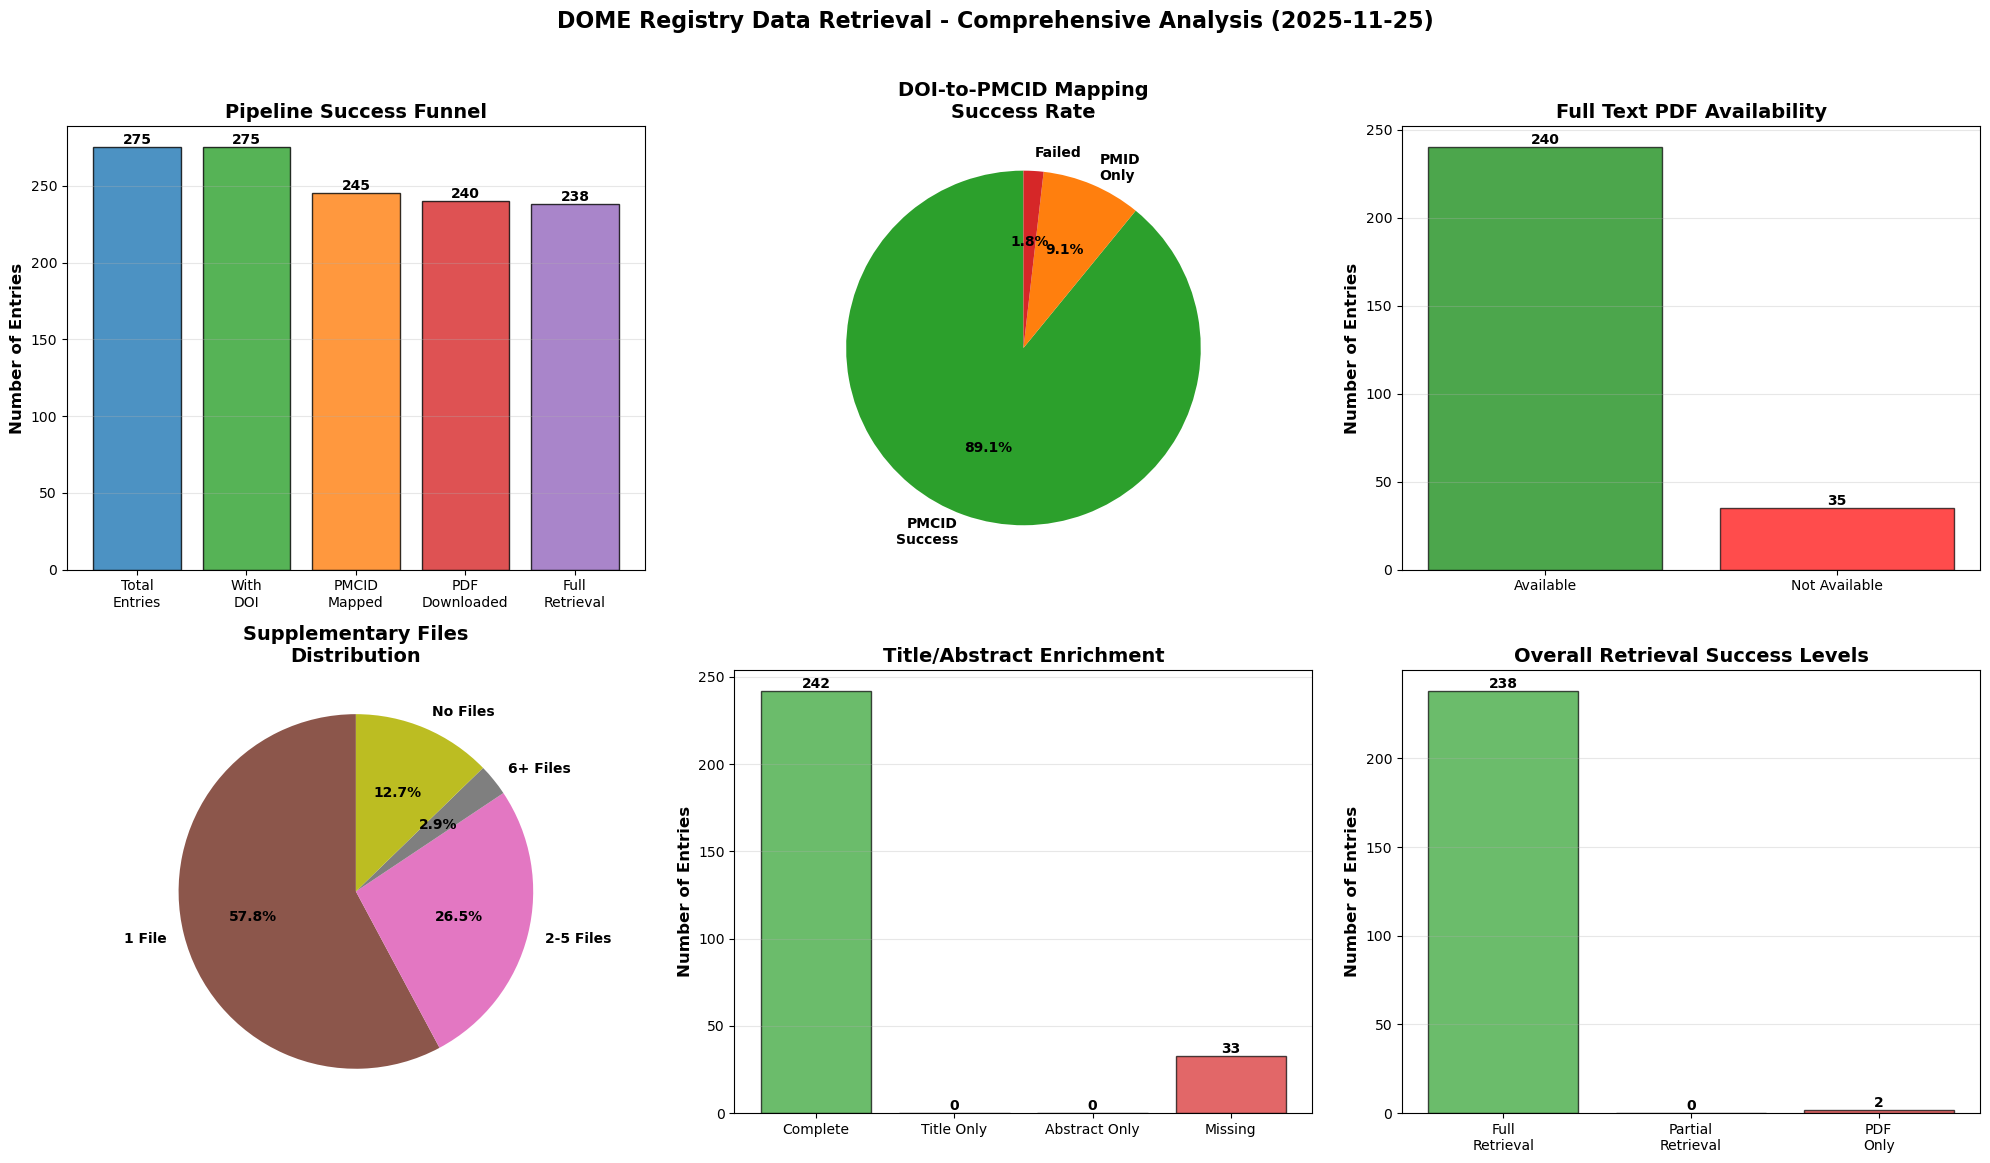


DOME REGISTRY DATA RETRIEVAL - FINAL SUMMARY
Total DOME Registry entries: 275
DOI-to-PMCID mapping success: 89.1%
PDF retrieval success: 98.0%
Supplementary files retrieved: 240 entries (408 files)
Title/Abstract enrichment: 98.8%

Full data retrieval: 238 entries (86.5%)

All metadata files saved to: DOME_Registry_TSV_Files/
  - DOME_Registry_TSV_Files/DOME_Metadata_Complete.tsv
  - DOME_Registry_TSV_Files/DOME_Metadata_Summary.txt
  - DOME_Registry_TSV_Files/DOME_Metadata_Complete_Analysis.png

Block 8 complete.


In [42]:
# 8. Create comprehensive metadata analysis and visualizations
import csv
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

print("="*60)
print("GENERATING COMPREHENSIVE METADATA REPORT")
print("="*60)

# Read in the final TSV file
df = pd.read_csv(output_tsv_file_name, sep='\t')

# ============================================================================
# SECTION 1: DOME REGISTRY RETRIEVAL METRICS
# ============================================================================
print("\n1. Analyzing DOME Registry retrieval...")

total_entries = len(df)
entries_with_doi = df['publication_doi'].notna().sum()
entries_without_doi = total_entries - entries_with_doi

print(f"  Total DOME Registry entries: {total_entries}")
print(f"  Entries with DOI: {entries_with_doi}")
print(f"  Entries without DOI: {entries_without_doi}")

# ============================================================================
# SECTION 2: DOI-TO-PMCID MAPPING METRICS
# ============================================================================
print("\n2. Analyzing DOI-to-PMCID mapping success...")

entries_with_pmcid = df['mapped_pmcid'].notna().sum()
entries_with_pmid = df['mapped_pmid'].notna().sum()
entries_with_pmid_only = (df['mapped_pmid'].notna() & df['mapped_pmcid'].isna()).sum()
entries_with_europepmc_id = df['mapped_europepmc_id'].notna().sum()

# Calculate mapping success rate
mapping_success = entries_with_pmcid
mapping_attempted = entries_with_doi
mapping_success_rate = (mapping_success / mapping_attempted * 100) if mapping_attempted > 0 else 0

print(f"  DOIs processed: {mapping_attempted}")
print(f"  Successfully mapped to PMCID: {entries_with_pmcid} ({mapping_success_rate:.1f}%)")
print(f"  Mapped to PMID only (no PMCID): {entries_with_pmid_only}")
print(f"  Total with Europe PMC ID: {entries_with_europepmc_id}")

# ============================================================================
# SECTION 3: FULL TEXT PDF RETRIEVAL METRICS
# ============================================================================
print("\n3. Analyzing full text PDF retrieval...")

pdf_available = df['pdf_downloadable'].value_counts().get('yes', 0)
pdf_not_available = df['pdf_downloadable'].value_counts().get('no', 0)
pdf_success_rate = (pdf_available / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  PDFs successfully downloaded: {pdf_available} ({pdf_success_rate:.1f}% of PMCIDs)")
print(f"  PDFs not available: {pdf_not_available}")

# ============================================================================
# SECTION 4: SUPPLEMENTARY FILES METRICS
# ============================================================================
print("\n4. Analyzing supplementary files retrieval...")

entries_with_supp = (df['supplementary_file_count'] > 0).sum()
entries_without_supp = total_entries - entries_with_supp
total_supp_files = int(df['supplementary_file_count'].sum())

# Breakdown by number of supplementary files
supp_file_distribution = df[df['supplementary_file_count'] > 0]['supplementary_file_count'].value_counts().sort_index()
entries_with_1_file = supp_file_distribution.get(1, 0)
entries_with_2_5_files = supp_file_distribution[(supp_file_distribution.index >= 2) & (supp_file_distribution.index <= 5)].sum()
entries_with_6plus_files = supp_file_distribution[supp_file_distribution.index > 5].sum()

avg_supp_per_entry = (total_supp_files / entries_with_supp) if entries_with_supp > 0 else 0
supp_success_rate = (entries_with_supp / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  Entries with supplementary files: {entries_with_supp} ({supp_success_rate:.1f}% of PMCIDs)")
print(f"  Total supplementary files downloaded: {total_supp_files}")
print(f"  Average files per entry (with supp): {avg_supp_per_entry:.2f}")
print(f"  Entries with 1 file: {entries_with_1_file}")
print(f"  Entries with 2-5 files: {entries_with_2_5_files}")
print(f"  Entries with 6+ files: {entries_with_6plus_files}")

# ============================================================================
# SECTION 5: TITLE/ABSTRACT ENRICHMENT METRICS
# ============================================================================
print("\n5. Analyzing title/abstract enrichment...")

title_abstract_available = (df['article_title'].notna() & df['article_abstract'].notna()).sum()
title_only = (df['article_title'].notna() & df['article_abstract'].isna()).sum()
abstract_only = (df['article_title'].isna() & df['article_abstract'].notna()).sum()
title_abstract_missing = total_entries - title_abstract_available - title_only - abstract_only

enrichment_success_rate = (title_abstract_available / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  Complete title & abstract: {title_abstract_available} ({enrichment_success_rate:.1f}% of PMCIDs)")
print(f"  Title only: {title_only}")
print(f"  Abstract only: {abstract_only}")
print(f"  Neither available: {title_abstract_missing}")

# ============================================================================
# SECTION 6: OVERALL SUCCESS METRICS
# ============================================================================
print("\n6. Calculating overall pipeline success...")

# Full data retrieval success (PDF + Supp + Title/Abstract)
full_success = ((df['pdf_downloadable'] == 'yes') & 
                (df['supplementary_file_count'] > 0) & 
                (df['article_title'].notna()) & 
                (df['article_abstract'].notna())).sum()

# Partial success (PDF + Title/Abstract, no supp required)
partial_success = ((df['pdf_downloadable'] == 'yes') & 
                   (df['article_title'].notna()) & 
                   (df['article_abstract'].notna())).sum()

# At least PDF
pdf_only_success = (df['pdf_downloadable'] == 'yes').sum()

print(f"  Full data retrieval (PDF + Supp + Title/Abstract): {full_success} ({full_success/total_entries*100:.1f}%)")
print(f"  PDF + Title/Abstract (no supp required): {partial_success} ({partial_success/total_entries*100:.1f}%)")
print(f"  At least PDF available: {pdf_only_success} ({pdf_only_success/total_entries*100:.1f}%)")

# ============================================================================
# SECTION 7: CREATE COMPREHENSIVE METADATA TSV
# ============================================================================
print("\n7. Creating metadata TSV file...")

metadata = pd.DataFrame({
    'Metric': [
        # DOME Registry
        'Total DOME Registry Entries',
        'Entries with DOI',
        'Entries without DOI',
        '',
        # DOI Mapping
        'DOI Mapping - Attempted',
        'DOI Mapping - Success (PMCID)',
        'DOI Mapping - Success Rate (%)',
        'DOI Mapping - PMID Only',
        'DOI Mapping - Europe PMC ID',
        '',
        # PDF Retrieval
        'PDF - Successfully Downloaded',
        'PDF - Not Available',
        'PDF - Success Rate (% of PMCIDs)',
        '',
        # Supplementary Files
        'Supplementary - Entries with Files',
        'Supplementary - Total Files Count',
        'Supplementary - Avg Files per Entry',
        'Supplementary - Success Rate (% of PMCIDs)',
        'Supplementary - Entries with 1 File',
        'Supplementary - Entries with 2-5 Files',
        'Supplementary - Entries with 6+ Files',
        '',
        # Title/Abstract
        'Title/Abstract - Complete',
        'Title/Abstract - Title Only',
        'Title/Abstract - Abstract Only',
        'Title/Abstract - Neither',
        'Title/Abstract - Success Rate (% of PMCIDs)',
        '',
        # Overall Success
        'Overall - Full Retrieval (PDF+Supp+Title/Abstract)',
        'Overall - Partial Retrieval (PDF+Title/Abstract)',
        'Overall - Minimum Retrieval (PDF Only)'
    ],
    'Count': [
        # DOME Registry
        total_entries,
        entries_with_doi,
        entries_without_doi,
        '',
        # DOI Mapping
        mapping_attempted,
        entries_with_pmcid,
        f"{mapping_success_rate:.1f}",
        entries_with_pmid_only,
        entries_with_europepmc_id,
        '',
        # PDF Retrieval
        pdf_available,
        pdf_not_available,
        f"{pdf_success_rate:.1f}",
        '',
        # Supplementary Files
        entries_with_supp,
        total_supp_files,
        f"{avg_supp_per_entry:.2f}",
        f"{supp_success_rate:.1f}",
        entries_with_1_file,
        entries_with_2_5_files,
        entries_with_6plus_files,
        '',
        # Title/Abstract
        title_abstract_available,
        title_only,
        abstract_only,
        title_abstract_missing,
        f"{enrichment_success_rate:.1f}",
        '',
        # Overall Success
        full_success,
        partial_success,
        pdf_only_success
    ]
})

metadata_tsv_path = 'DOME_Registry_TSV_Files/DOME_Metadata_Complete.tsv'
metadata.to_csv(metadata_tsv_path, sep='\t', index=False)
print(f"  ✓ Metadata TSV saved to '{metadata_tsv_path}'")

# ============================================================================
# SECTION 8: CREATE DETAILED TEXT SUMMARY
# ============================================================================
print("\n8. Creating detailed text summary...")

summary_text_path = 'DOME_Registry_TSV_Files/DOME_Metadata_Summary.txt'
with open(summary_text_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("DOME REGISTRY DATA RETRIEVAL - COMPREHENSIVE SUMMARY\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. DOME REGISTRY RETRIEVAL\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total entries retrieved: {total_entries}\n")
    f.write(f"Entries with DOI: {entries_with_doi} ({entries_with_doi/total_entries*100:.1f}%)\n")
    f.write(f"Entries without DOI: {entries_without_doi} ({entries_without_doi/total_entries*100:.1f}%)\n")
    f.write(f"\nNOTE: DOIs are required for PubMed/PMC mapping and full-text retrieval.\n")
    f.write(f"Entries without DOIs cannot be processed further.\n\n")
    
    f.write("2. DOI-TO-PMCID MAPPING (via NCBI E-Utilities)\n")
    f.write("-" * 80 + "\n")
    f.write(f"DOIs submitted for mapping: {mapping_attempted}\n")
    f.write(f"Successfully mapped to PMCID: {entries_with_pmcid} ({mapping_success_rate:.1f}%)\n")
    f.write(f"Mapped to PMID only (no PMCID): {entries_with_pmid_only}\n")
    f.write(f"Total with Europe PMC identifier: {entries_with_europepmc_id}\n")
    f.write(f"\nNOTE: PMCIDs are required for open-access content retrieval.\n")
    f.write(f"Articles without PMCIDs may be behind paywalls or not in PMC.\n\n")
    
    f.write("3. FULL TEXT PDF RETRIEVAL (via Europe PMC)\n")
    f.write("-" * 80 + "\n")
    f.write(f"PDFs successfully downloaded: {pdf_available}\n")
    f.write(f"Success rate: {pdf_success_rate:.1f}% of entries with PMCIDs\n")
    f.write(f"PDFs not available: {pdf_not_available}\n")
    f.write(f"\nNOTE: PDF availability depends on open-access status and publisher policies.\n")
    f.write(f"Some articles may require institutional access.\n\n")
    
    f.write("4. SUPPLEMENTARY FILES RETRIEVAL (via NCBI PMC OA)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Entries with supplementary files: {entries_with_supp} ({supp_success_rate:.1f}% of PMCIDs)\n")
    f.write(f"Total supplementary files downloaded: {total_supp_files}\n")
    f.write(f"Average files per entry (with supp): {avg_supp_per_entry:.2f}\n\n")
    f.write("Distribution by number of files:\n")
    f.write(f"  - 1 file: {entries_with_1_file} entries\n")
    f.write(f"  - 2-5 files: {entries_with_2_5_files} entries\n")
    f.write(f"  - 6+ files: {entries_with_6plus_files} entries\n")
    f.write(f"\nNOTE: Only human-readable files (PDF, DOC, TXT, CSV, etc.) are extracted.\n")
    f.write(f"Supplementary files are only available for open-access articles.\n\n")
    
    f.write("5. TITLE & ABSTRACT ENRICHMENT (via Europe PMC)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Complete title & abstract: {title_abstract_available} ({enrichment_success_rate:.1f}% of PMCIDs)\n")
    f.write(f"Title only: {title_only}\n")
    f.write(f"Abstract only: {abstract_only}\n")
    f.write(f"Neither available: {title_abstract_missing}\n")
    f.write(f"\nNOTE: Metadata enrichment enhances searchability and analysis capabilities.\n\n")
    
    f.write("6. OVERALL PIPELINE SUCCESS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Full data retrieval (PDF + Supp + Title/Abstract): {full_success} ({full_success/total_entries*100:.1f}%)\n")
    f.write(f"Partial retrieval (PDF + Title/Abstract): {partial_success} ({partial_success/total_entries*100:.1f}%)")
    f.write(f"Minimum retrieval (PDF only): {pdf_only_success} ({pdf_only_success/total_entries*100:.1f}%)\n\n")
    
    f.write("7. DATA LOCATIONS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Main TSV file: {output_tsv_file_name}\n")
    f.write(f"Full text PDFs: DOME_Registry_PMC_PDFs/\n")
    f.write(f"Supplementary files: DOME_Registry_PMC_Supplementary/\n")
    f.write(f"Metadata files: DOME_Registry_TSV_Files/\n\n")
    
    f.write("="*80 + "\n")
    f.write("END OF SUMMARY\n")
    f.write("="*80 + "\n")

print(f"  ✓ Summary text saved to '{summary_text_path}'")

# ============================================================================
# SECTION 9: CREATE COMPREHENSIVE VISUALIZATIONS
# ============================================================================
print("\n9. Creating comprehensive visualizations...")

# Create a larger figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# Plot 1: Overall Pipeline Success
ax1 = plt.subplot(2, 3, 1)
pipeline_stages = ['Total\nEntries', 'With\nDOI', 'PMCID\nMapped', 'PDF\nDownloaded', 'Full\nRetrieval']
pipeline_counts = [total_entries, entries_with_doi, entries_with_pmcid, pdf_available, full_success]
colors_pipeline = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd']
bars1 = ax1.bar(pipeline_stages, pipeline_counts, color=colors_pipeline, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax1.set_title('Pipeline Success Funnel', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 2: DOI Mapping Success
ax2 = plt.subplot(2, 3, 2)
mapping_labels = ['PMCID\nSuccess', 'PMID\nOnly', 'Failed']
mapping_values = [entries_with_pmcid, entries_with_pmid_only, 
                  mapping_attempted - entries_with_pmcid - entries_with_pmid_only]
colors_mapping = ['#2ca02c', '#ff7f0e', '#d62728']
wedges2, texts2, autotexts2 = ax2.pie(mapping_values, labels=mapping_labels, autopct='%1.1f%%',
                                        colors=colors_mapping, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('DOI-to-PMCID Mapping\nSuccess Rate', fontsize=14, fontweight='bold')

# Plot 3: PDF Availability
ax3 = plt.subplot(2, 3, 3)
pdf_labels = ['Available', 'Not Available']
pdf_values = [pdf_available, pdf_not_available]
colors_pdf = ['green', 'red']
bars3 = ax3.bar(pdf_labels, pdf_values, color=colors_pdf, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax3.set_title('Full Text PDF Availability', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 4: Supplementary Files Distribution
ax4 = plt.subplot(2, 3, 4)
supp_labels = ['1 File', '2-5 Files', '6+ Files', 'No Files']
supp_values = [entries_with_1_file, entries_with_2_5_files, 
               entries_with_6plus_files, entries_without_supp]
colors_supp = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
wedges4, texts4, autotexts4 = ax4.pie(supp_values, labels=supp_labels, autopct='%1.1f%%',
                                        colors=colors_supp, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Supplementary Files\nDistribution', fontsize=14, fontweight='bold')

# Plot 5: Title/Abstract Enrichment
ax5 = plt.subplot(2, 3, 5)
enrichment_labels = ['Complete', 'Title Only', 'Abstract Only', 'Missing']
enrichment_values = [title_abstract_available, title_only, abstract_only, title_abstract_missing]
colors_enrich = ['#2ca02c', '#ff7f0e', '#1f77b4', '#d62728']
bars5 = ax5.bar(enrichment_labels, enrichment_values, color=colors_enrich, alpha=0.7, edgecolor='black')
ax5.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax5.set_title('Title/Abstract Enrichment', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar in bars5:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 6: Overall Success Levels
ax6 = plt.subplot(2, 3, 6)
success_labels = ['Full\nRetrieval', 'Partial\nRetrieval', 'PDF\nOnly']
success_values = [full_success, partial_success - full_success, pdf_only_success - partial_success]
colors_success = ['#2ca02c', '#ff7f0e', '#d62728']
bars6 = ax6.bar(success_labels, success_values, color=colors_success, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax6.set_title('Overall Retrieval Success Levels', fontsize=14, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for bar in bars6:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Add overall title
fig.suptitle(f'DOME Registry Data Retrieval - Comprehensive Analysis ({current_date})', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Save the comprehensive plot
plot_image_path = 'DOME_Registry_TSV_Files/DOME_Metadata_Complete_Analysis.png'
plt.savefig(plot_image_path, dpi=300, bbox_inches='tight')
print(f"  ✓ Comprehensive charts saved to '{plot_image_path}'")

plt.show()

# ============================================================================
# FINAL SUMMARY PRINTOUT
# ============================================================================
print("\n" + "="*60)
print("DOME REGISTRY DATA RETRIEVAL - FINAL SUMMARY")
print("="*60)
print(f"Total DOME Registry entries: {total_entries}")
print(f"DOI-to-PMCID mapping success: {mapping_success_rate:.1f}%")
print(f"PDF retrieval success: {pdf_success_rate:.1f}%")
print(f"Supplementary files retrieved: {entries_with_supp} entries ({total_supp_files} files)")
print(f"Title/Abstract enrichment: {enrichment_success_rate:.1f}%")
print(f"\nFull data retrieval: {full_success} entries ({full_success/total_entries*100:.1f}%)")
print("="*60)
print(f"\nAll metadata files saved to: DOME_Registry_TSV_Files/")
print(f"  - {metadata_tsv_path}")
print(f"  - {summary_text_path}")
print(f"  - {plot_image_path}")
print("="*60)

print("\nBlock 8 complete.")

## 9. Identify and export failed DOI mappings for manual remediation and verification

In [17]:
# 9. Identify DOIs that failed to map to PMID/PMCID and export for remediation
import pandas as pd
import os
import re
import glob
from datetime import datetime

print("="*60)
print("ANALYZING FAILED DOI MAPPINGS FOR REMEDIATION")
print("="*60)

# Read in the final TSV file
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Create Remediation folder
remediation_folder = 'DOME_Registry_Remediation'
os.makedirs(remediation_folder, exist_ok=True)
print(f"\nCreated/verified remediation folder: {remediation_folder}/")

# ============================================================================
# SECTION 1: IDENTIFY FAILED MAPPINGS
# ============================================================================
print("\n1. Identifying entries with failed DOI-to-PMCID mappings...")

# Filter entries with DOIs but no PMCID mapping
failed_mappings = df[
    (df['publication_doi'].notna()) & 
    (df['mapped_pmcid'].isna())
].copy()

total_failed = len(failed_mappings)
print(f"  Found {total_failed} entries with DOIs that failed to map to PMCID")

# Check for previously remediated entries to exclude
tsv_folder = 'DOME_Registry_TSV_Files'
remediation_pattern = os.path.join(tsv_folder, 'remediated_Failed_DOI_Mappings_*.tsv')
remediation_files = glob.glob(remediation_pattern)

if remediation_files:
    print(f"\n  Checking {len(remediation_files)} existing remediation file(s) for already processed entries...")
    remediated_ids = set()
    
    for r_file in remediation_files:
        try:
            r_df = pd.read_csv(r_file, sep='\t')
            # Identify columns
            id_col = 'shortid' if 'shortid' in r_df.columns else ('_id' if '_id' in r_df.columns else None)
            
            if id_col and 'Remediation_Status' in r_df.columns:
                # Get IDs that are marked as done (RESOLVED or NOT_IN_PUBMED or DOI_ERROR)
                # Basically anything that isn't 'NEEDS_REVIEW'
                done_entries = r_df[r_df['Remediation_Status'] != 'NEEDS_REVIEW'][id_col].tolist()
                remediated_ids.update(done_entries)
        except Exception as e:
            print(f"    Warning: Could not read {os.path.basename(r_file)}: {e}")
            
    print(f"  Found {len(remediated_ids)} entries already marked as remediated/resolved.")
    
    # Filter out these IDs from failed_mappings
    id_col_main = 'shortid' if 'shortid' in failed_mappings.columns else '_id'
    if id_col_main in failed_mappings.columns:
        initial_count = len(failed_mappings)
        failed_mappings = failed_mappings[~failed_mappings[id_col_main].isin(remediated_ids)]
        filtered_count = len(failed_mappings)
        print(f"  Excluded {initial_count - filtered_count} entries. Remaining to remediate: {filtered_count}")
        total_failed = filtered_count

if total_failed == 0:
    print("  ✓ All DOIs successfully mapped or already remediated! No new remediation needed.")
    print("\nBlock 9 complete.")
else:
    # ============================================================================
    # SECTION 2: PREPARE REMEDIATION DATA WITH CLEANED DOIS
    # ============================================================================
    print("\n2. Preparing remediation data with cleaned DOIs...")
    
    # Function to clean and normalize DOI strings (same as Block 4)
    def clean_doi(doi_string):
        """Clean DOI string by removing common prefixes and URLs."""
        if pd.isna(doi_string):
            return None
        
        doi_string = str(doi_string).strip()
        doi_string = re.sub(r'^https?://doi\.org/', '', doi_string, flags=re.IGNORECASE)
        doi_string = re.sub(r'^https?://dx\.doi\.org/', '', doi_string, flags=re.IGNORECASE)
        doi_string = re.sub(r'^https?://www\.doi\.org/', '', doi_string, flags=re.IGNORECASE)
        doi_string = re.sub(r'^doi:\s*', '', doi_string, flags=re.IGNORECASE)
        
        doi_string = doi_string.strip()
        return doi_string
    
    # Select relevant columns for remediation
    remediation_columns = []
    
    # Add key identifier columns if they exist
    if 'shortid' in failed_mappings.columns:
        remediation_columns.append('shortid')
    if '_id' in failed_mappings.columns:
        remediation_columns.append('_id')
    
    # Add publication metadata
    publication_cols = ['publication_doi', 'publication_title', 'publication_year', 
                       'publication_journal', 'publication_authors_0_name']
    for col in publication_cols:
        if col in failed_mappings.columns:
            remediation_columns.append(col)
    
    # Add mapping attempt results
    mapping_cols = ['mapped_pmcid', 'mapped_pmid', 'mapped_europepmc_id']
    for col in mapping_cols:
        if col in failed_mappings.columns:
            remediation_columns.append(col)
    
    # Create clean remediation dataframe
    remediation_df = failed_mappings[remediation_columns].copy()
    
    # Add cleaned DOI column
    remediation_df['DOI_Cleaned'] = remediation_df['publication_doi'].apply(clean_doi)
    
    # Add clickable DOI links using cleaned DOI
    remediation_df['DOI_Link'] = remediation_df['DOI_Cleaned'].apply(
        lambda x: f"https://doi.org/{x}" if pd.notna(x) else None
    )
    
    # Reorder columns to put cleaned DOI and link first
    cols = remediation_df.columns.tolist()
    # Move DOI_Cleaned and DOI_Link after publication_doi
    doi_idx = cols.index('publication_doi')
    cols.remove('DOI_Cleaned')
    cols.remove('DOI_Link')
    cols.insert(doi_idx + 1, 'DOI_Cleaned')
    cols.insert(doi_idx + 2, 'DOI_Link')
    remediation_df = remediation_df[cols]
    
    # Add status column for tracking
    remediation_df['Remediation_Status'] = 'NEEDS_REVIEW'
    remediation_df['Remediation_Notes'] = ''
    remediation_df['Manual_PMCID'] = ''
    remediation_df['Manual_PMID'] = ''
    
    # ============================================================================
    # SECTION 3: EXPORT REMEDIATION FILE
    # ============================================================================
    print("\n3. Exporting remediation file...")
    
    # Export as TSV (better for text data with special characters)
    remediation_tsv_path = os.path.join(remediation_folder, f'Failed_DOI_Mappings_{current_date}.tsv')
    remediation_df.to_csv(remediation_tsv_path, sep='\t', index=False)
    print(f"  ✓ Remediation TSV saved: {remediation_tsv_path}")
    
    # ============================================================================
    # SECTION 4: CREATE CLICKABLE HTML REPORT
    # ============================================================================
    print("\n4. Creating clickable HTML report...")
    
    html_path = os.path.join(remediation_folder, f'Failed_DOI_Mappings_Report_{current_date}.html')
    
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write("<!DOCTYPE html>\n<html>\n<head>\n")
        f.write("<meta charset='UTF-8'>\n")
        f.write("<title>DOME Registry - Failed DOI Mappings</title>\n")
        f.write("<style>\n")
        f.write("body { font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }\n")
        f.write("h1 { color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }\n")
        f.write("h2 { color: #34495e; margin-top: 30px; }\n")
        f.write("table { border-collapse: collapse; width: 100%; background-color: white; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }\n")
        f.write("th { background-color: #3498db; color: white; padding: 12px; text-align: left; font-weight: bold; }\n")
        f.write("td { padding: 10px; border-bottom: 1px solid #ddd; }\n")
        f.write("tr:hover { background-color: #f5f5f5; }\n")
        f.write("a { color: #3498db; text-decoration: none; font-weight: bold; }\n")
        f.write("a:hover { color: #2980b9; text-decoration: underline; }\n")
        f.write(".stats { background-color: #ecf0f1; padding: 15px; border-radius: 5px; margin: 20px 0; }\n")
        f.write(".stats p { margin: 5px 0; }\n")
        f.write(".warning { color: #e74c3c; font-weight: bold; }\n")
        f.write(".info { color: #16a085; }\n")
        f.write(".original-doi { color: #7f8c8d; font-size: 0.85em; font-style: italic; }\n")
        f.write("</style>\n")
        f.write("</head>\n<body>\n")
        
        # Header
        f.write(f"<h1>DOME Registry - Failed DOI Mappings Report</h1>\n")
        f.write(f"<p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>\n")
        
        # Statistics
        f.write("<div class='stats'>\n")
        f.write(f"<h2>Summary Statistics</h2>\n")
        f.write(f"<p><strong>Total failed mappings:</strong> <span class='warning'>{total_failed}</span></p>\n")
        f.write(f"<p><strong>Total DOME Registry entries:</strong> {len(df)}</p>\n")
        f.write(f"<p><strong>Entries with DOIs:</strong> {df['publication_doi'].notna().sum()}</p>\n")
        f.write(f"<p><strong>Success rate:</strong> <span class='info'>{((df['publication_doi'].notna().sum() - total_failed) / df['publication_doi'].notna().sum() * 100):.1f}%</span></p>\n")
        f.write("</div>\n")
        
        # Instructions
        f.write("<h2>Instructions for Remediation</h2>\n")
        f.write("<ol>\n")
        f.write("<li>Click on the <strong>cleaned DOI links</strong> to verify if the articles exist and are accessible</li>\n")
        f.write("<li>Search for the article on <a href='https://pubmed.ncbi.nlm.nih.gov/' target='_blank'>PubMed</a> using the cleaned DOI or title</li>\n")
        f.write("<li>If found, note the PMID/PMCID in the remediation <strong>TSV file</strong></li>\n")
        f.write("<li>Check if the original DOI has formatting issues (shown in gray below cleaned DOI)</li>\n")
        f.write("<li>Some articles may not be indexed in PubMed/PMC yet (recently published)</li>\n")
        f.write("</ol>\n")
        
        # Table
        f.write("<h2>Failed Mappings Table</h2>\n")
        f.write("<table>\n")
        f.write("<tr>\n")
        
        # Table headers
        display_headers = ['DOME ID', 'DOI (Cleaned)', 'Link', 'Title', 'Year', 'Journal']
        
        for header in display_headers:
            f.write(f"<th>{header}</th>\n")
        f.write("</tr>\n")
        
        # Table rows
        for idx, row in remediation_df.iterrows():
            f.write("<tr>\n")
            
            # DOME ID
            dome_id = row.get('shortid', 'N/A')
            f.write(f"<td>{dome_id}</td>\n")
            
            # DOI (show cleaned DOI with original below)
            doi_cleaned = row.get('DOI_Cleaned', 'N/A')
            doi_original = row.get('publication_doi', '')
            f.write(f"<td style='font-size: 0.9em;'>{doi_cleaned}")
            if pd.notna(doi_original) and str(doi_original) != str(doi_cleaned):
                f.write(f"<br><span class='original-doi'>Original: {doi_original}</span>")
            f.write("</td>\n")
            
            # DOI Link (using cleaned DOI)
            doi_link = row.get('DOI_Link', '')
            if pd.notna(doi_link):
                f.write(f"<td><a href='{doi_link}' target='_blank'>Open DOI</a></td>\n")
            else:
                f.write("<td>N/A</td>\n")
            
            # Title
            title = row.get('publication_title', 'N/A')
            if pd.notna(title) and len(str(title)) > 100:
                title = str(title)[:100] + "..."
            f.write(f"<td>{title}</td>\n")
            
            # Year
            year = row.get('publication_year', 'N/A')
            f.write(f"<td>{year}</td>\n")
            
            # Journal
            journal = row.get('publication_journal', 'N/A')
            if pd.notna(journal) and len(str(journal)) > 50:
                journal = str(journal)[:50] + "..."
            f.write(f"<td>{journal}</td>\n")
            
            f.write("</tr>\n")
        
        f.write("</table>\n")
        
        # Footer
        f.write("<div style='margin-top: 30px; padding: 20px; background-color: #ecf0f1; border-radius: 5px;'>\n")
        f.write("<h2>Next Steps</h2>\n")
        f.write("<p>1. Use the TSV file to track remediation progress</p>\n")
        f.write("<p>2. Update 'Remediation_Status' column as you verify each entry</p>\n")
        f.write("<p>3. Add manual PMID/PMCID values if found</p>\n")
        f.write("<p>4. Re-import the remediated data for complete pipeline processing</p>\n")
        f.write("<p><strong>Note:</strong> The 'DOI_Cleaned' column shows normalized DOIs (URLs removed). Use these for searches.</p>\n")
        f.write("<p><strong>TSV Format:</strong> Tab-separated values preserve special characters and complex text better than CSV.</p>\n")
        f.write("</div>\n")
        
        f.write("</body>\n</html>")
    
    print(f"  ✓ HTML report saved: {html_path}")
    
    # ============================================================================
    # SECTION 5: CREATE REMEDIATION INSTRUCTIONS
    # ============================================================================
    print("\n5. Creating remediation instructions...")
    
    instructions_path = os.path.join(remediation_folder, 'REMEDIATION_INSTRUCTIONS.txt')
    
    with open(instructions_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("DOME REGISTRY - FAILED DOI MAPPINGS REMEDIATION INSTRUCTIONS\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*80 + "\n\n")
        
        f.write("OVERVIEW\n")
        f.write("-" * 80 + "\n")
        f.write(f"Total failed mappings: {total_failed}\n")
        f.write(f"These DOIs were present in DOME Registry but could not be mapped to\n")
        f.write(f"PMID/PMCID identifiers via NCBI E-Utilities API.\n\n")
        
        f.write("POSSIBLE REASONS FOR FAILURE\n")
        f.write("-" * 80 + "\n")
        f.write("1. Article not indexed in PubMed/PMC database\n")
        f.write("2. DOI format error or typo in DOME Registry\n")
        f.write("3. Recently published article (not yet indexed)\n")
        f.write("4. Article from non-PubMed indexed journal\n")
        f.write("5. Preprint or non-peer-reviewed article\n\n")
        
        f.write("REMEDIATION STEPS\n")
        f.write("-" * 80 + "\n")
        f.write("1. Open the HTML report for easy DOI link navigation\n")
        f.write(f"   File: {html_path}\n\n")
        
        f.write("2. For each failed DOI:\n")
        f.write("   a. Click the DOI link to verify article exists\n")
        f.write("   b. Search PubMed using DOI or article title:\n")
        f.write("      https://pubmed.ncbi.nlm.nih.gov/\n")
        f.write("   c. If found, note the PMID (and PMCID if available)\n")
        f.write("   d. Update the remediation TSV with:\n")
        f.write("      - Manual_PMID column\n")
        f.write("      - Manual_PMCID column (if available)\n")
        f.write("      - Remediation_Status: 'RESOLVED' or 'NOT_IN_PUBMED'\n")
        f.write("      - Remediation_Notes: Brief explanation\n\n")
        
        f.write("3. Common remediation scenarios:\n\n")
        f.write("   SCENARIO A: Article found in PubMed\n")
        f.write("   - Manual_PMID: <paste PMID>\n")
        f.write("   - Manual_PMCID: <paste PMCID if available>\n")
        f.write("   - Remediation_Status: RESOLVED\n")
        f.write("   - Remediation_Notes: Found via manual search\n\n")
        
        f.write("   SCENARIO B: Article not in PubMed\n")
        f.write("   - Manual_PMID: (leave empty)\n")
        f.write("   - Manual_PMCID: (leave empty)\n")
        f.write("   - Remediation_Status: NOT_IN_PUBMED\n")
        f.write("   - Remediation_Notes: Journal not indexed in PubMed\n\n")
        
        f.write("   SCENARIO C: DOI error/broken\n")
        f.write("   - Manual_PMID: (leave empty or add correct if found)\n")
        f.write("   - Manual_PMCID: (leave empty or add correct if found)\n")
        f.write("   - Remediation_Status: DOI_ERROR\n")
        f.write("   - Remediation_Notes: DOI link broken, needs correction in DOME\n\n")
        
        f.write("4. Save the updated TSV file\n\n")
        
        f.write("5. Re-import remediated data (optional future step):\n")
        f.write("   - Merge manual PMID/PMCID back into main dataset\n")
        f.write("   - Re-run download blocks for newly identified PMCIDs\n\n")
        
        f.write("FILES CREATED\n")
        f.write("-" * 80 + "\n")
        f.write(f"1. TSV file: {remediation_tsv_path}\n")
        f.write(f"2. HTML report: {html_path}\n")
        f.write(f"3. This file: {instructions_path}\n\n")
        
        f.write("NOTE ON TSV FORMAT\n")
        f.write("-" * 80 + "\n")
        f.write("TSV (Tab-Separated Values) is used instead of CSV because:\n")
        f.write("- Better handling of commas in text (titles, journal names)\n")
        f.write("- Preserves special characters and unicode\n")
        f.write("- More robust for scientific text and metadata\n")
        f.write("- Can be opened in Excel, LibreOffice, or any text editor\n\n")
        
    print(f"  ✓ Instructions saved: {instructions_path}")
    
    # ============================================================================
    # SECTION 6: SUMMARY STATISTICS
    # ============================================================================
    print("\n" + "="*60)
    print("REMEDIATION FILES SUMMARY")
    print("="*60)
    print(f"Failed mappings identified: {total_failed}")
    print(f"Remediation folder: {remediation_folder}/")
    print(f"\nFiles created:")
    print(f"  1. {os.path.basename(remediation_tsv_path)}")
    print(f"  2. {os.path.basename(html_path)}")
    print(f"  3. {os.path.basename(instructions_path)}")
    print("\nKey features:")
    print(f"  - DOIs have been cleaned (URLs and prefixes removed)")
    print(f"  - Original DOIs shown in HTML for comparison")
    print(f"  - Clickable links use cleaned DOI format")
    print(f"  - TSV format preserves complex text and special characters")
    print("\nNext steps:")
    print(f"  - Open the HTML report to review failed DOIs with clickable links")
    print(f"  - Follow instructions in REMEDIATION_INSTRUCTIONS.txt")
    print(f"  - Update TSV file with manual PMID/PMCID findings")
    print("="*60)

print("\nBlock 9 complete.")

ANALYZING FAILED DOI MAPPINGS FOR REMEDIATION

Created/verified remediation folder: DOME_Registry_Remediation/

1. Identifying entries with failed DOI-to-PMCID mappings...
  Found 31 entries with DOIs that failed to map to PMCID

  Checking 1 existing remediation file(s) for already processed entries...
  Found 33 entries already marked as remediated/resolved.
  Excluded 26 entries. Remaining to remediate: 5

2. Preparing remediation data with cleaned DOIs...

3. Exporting remediation file...
  ✓ Remediation TSV saved: DOME_Registry_Remediation/Failed_DOI_Mappings_2025-11-25.tsv

4. Creating clickable HTML report...
  ✓ HTML report saved: DOME_Registry_Remediation/Failed_DOI_Mappings_Report_2025-11-25.html

5. Creating remediation instructions...
  ✓ Instructions saved: DOME_Registry_Remediation/REMEDIATION_INSTRUCTIONS.txt

REMEDIATION FILES SUMMARY
Failed mappings identified: 5
Remediation folder: DOME_Registry_Remediation/

Files created:
  1. Failed_DOI_Mappings_2025-11-25.tsv
  2.